In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import seaborn as sns

In [ ]:
BASE_PATH = '/content/drive/MyDrive/Robustness-backup'
CORRUPTION_TYPES = {
    'blur': ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur'],
    'digital': ['contrast', 'elastic_transform', 'jpeg_compression', 'pixelate'],
    'noise': ['gaussian_noise', 'impulse_noise', 'shot_noise'],
    'weather': ['brightness', 'fog', 'frost', 'snow']
}

## Utils

In [ ]:
def save_json(output_name, data_dict):
    with open(output_name, 'w') as file:
        json.dump(data_dict, file)
    print("File save with success!")


def load_json(output_name):
    with open(output_name, 'r') as file:
        data_dict = json.load(file)
    print("File loaded with success!")

    return data_dict

def sum_levels(category_data):
    return {key: sum(levels.values()) for key, levels in category_data.items()}

def sum_corruption_error_by_corruption(corruption_error_data):
    return {category: sum_levels(corruption_error_data[category]) for category in corruption_error_data}

def sum_levels_relative(category_data, baseline_clean_error):
    result = {}
    for key, levels in category_data.items():
        total_sum = 0.
        for corruption_value in levels.values():
            total_sum += corruption_value - baseline_clean_error
        result[key] = total_sum
    return result


def sum_relative_corruption_error(corruption_error_data, baseline_clean_error):
    return {category: sum_levels_relative(corruption_error_data[category], baseline_clean_error) for category in
            corruption_error_data}


def generate_relative_and_corruption_error(sum_ce_model, sum_rel_ce_model, sum_ce_baseline, sum_rel_ce_baseline):
    ce_result = {}
    relative_ce_result = {}
    for key, corruptions in CORRUPTION_TYPES.items():
        for corruption in corruptions:
            corruption_error = sum_ce_model[key][corruption] / sum_ce_baseline[key][corruption]
            relative_corruption_error = sum_rel_ce_model[key][corruption] / sum_rel_ce_baseline[key][corruption]
            ce_result[corruption] = round(corruption_error * 100)
            relative_ce_result[corruption] = round(relative_corruption_error * 100)

    ce_result['mCE'] = round(sum(ce_result.values()) / 15, 1)
    relative_ce_result['Relative mCE'] = round(sum(relative_ce_result.values()) / 15, 1)
    return ce_result, relative_ce_result

def generate_metrics(corruption_error_to_evaluate, corruption_error_baseline, CLEAN_ERROR_TO_EVALUATE, CLEAN_ERROR_BASELINE):
    sum_ce_evaluate = sum_corruption_error_by_corruption(corruption_error_to_evaluate)
    sum_relative_ce_evaluate = sum_relative_corruption_error(corruption_error_to_evaluate, CLEAN_ERROR_TO_EVALUATE)

    sum_ce_baseline = sum_corruption_error_by_corruption(corruption_error_baseline)
    sum_relative_ce_baseline = sum_relative_corruption_error(corruption_error_baseline, CLEAN_ERROR_BASELINE)

    ce_result, relative_ce_result = generate_relative_and_corruption_error(sum_ce_evaluate, sum_relative_ce_evaluate, sum_ce_baseline, sum_relative_ce_baseline)

    return ce_result, relative_ce_result

In [ ]:
def get_output_compression(PATH, types_of_model):
  all_models = os.listdir(PATH)
  output_compression = {model_name: {} for model_name in all_models}
  for model in all_models:
    fold_path = os.path.join(PATH, model, 'models')

    if not os.path.isdir(fold_path):
      continue

    types_fold_path = os.listdir(fold_path)

    for type_fold in types_fold_path:
      type_fold_path = os.path.join(fold_path, type_fold)

      all_optimizations = os.listdir(type_fold_path)
      for optimization in all_optimizations:
        optimization_path = os.path.join(type_fold_path, optimization)

        for key, value in types_of_model.items():
          type_model = value.format(model_name=model)
          if type_model == optimization:
            output_compression[model].update({key: get_gzipped_model_size(optimization_path)})
  return output_compression

def get_model_size(output_compression):
  models_size = {}
  for model, result in output_compression.items():
    if not model in models_size:
      models_size[model] = {}
    for type_name, size in result.items():
      models_size[model][type_name] = result[type_name] / (1024*1024)

  return models_size

def get_compression_rate(output_compression):
  compression_rate = {}
  for model, result in output_compression.items():
    if not model in compression_rate:
      compression_rate[model] = {}
    for type_name, size in result.items():
      compression_rate[model][type_name] = (result['Original'] if 'Original' in result else 0)/ size

  return compression_rate

def generate_df_compression(compression_rate):
  flattened_data = []

  for model_name, model_data in compression_rate.items():
    for type_name, value in model_data.items():
        row = {'Model': model_name, 'Type': type_name, 'Compression Rate': value}
        flattened_data.append(row)
  df_compression = pd.DataFrame(flattened_data)
  df_compression.set_index(['Model', 'Type'], inplace=True)

  return df_compression

# Consumption

In [ ]:
models = ['resnet50', 'mobilenet_v2', 'vgg19']
consumptions = {
    "Original": 'consumption_{model_name}{index}.csv',
    'Quantization Int8': 'consumption_{model_name}_full_integer{index}.csv',
    'Pruning': 'consumption_{model_name}_pruning_50{index}.csv',
    'Pruning Int8': 'consumption_{model_name}_pruning_50_full_integer{index}.csv',
    'Clustering': 'consumption_{model_name}_clustering_16{index}.csv',
    'Clustering Int8': 'consumption_{model_name}_clustering_16_full_integer{index}.csv',
    'Pruning with Clustering': 'consumption_{model_name}_pruning_50_clustering_16{index}.csv',
    'Pruning with Clustering Int8': 'consumption_{model_name}_pruning_50_clustering_16_full_integer{index}.csv',
    'QAT':'consumption_{model_name}_qat{index}.csv',
    'QAT Int8': 'consumption_{model_name}_qat_full_integer{index}.csv',
    'CQAT': 'consumption_{model_name}_clustering_16_qat{index}.csv',
    'CQAT Int8': 'consumption_{model_name}_clustering_16_qat_full_integer{index}.csv',
    'PQAT': 'consumption_{model_name}_pruning_50_qat{index}.csv',
    'PQAT Int8': 'consumption_{model_name}_pruning_50_qat_full_integer{index}.csv',
    'PCQAT': 'consumption_{model_name}_pruning_50_clustering_16_qat{index}.csv',
    'PCQAT Int8': 'consumption_{model_name}_pruning_50_clustering_16_qat_full_integer{index}.csv',
}

In [ ]:
def remove_first_and_last_ten_second(df):
  first_time = df.iloc[0]['uptime_s']
  last_time = df.iloc[-1]['uptime_s']
  filtered_df = df[(df['uptime_s'] > first_time + 10) & (df["uptime_s"] < last_time - 10)]
  return filtered_df

In [ ]:
VOLTS = 5.0 # Raspberry Pi 4

In [ ]:
all_consumptions = {}
for model in models:
    all_consumptions[model] = {}
    for dataset in ['cifar10', 'cifar100']:
        all_consumptions[model][dataset] = {}
        for key, value in consumptions.items():
            all_charges = []
            for i in range(9):
              if i == 0:
                file_name = value.format(model_name=model, index="")
              elif i == 3:
                continue
              else:
                file_name = value.format(model_name=model, index=f"_{i+1}")
              result = pd.read_csv(f'{BASE_PATH}/{dataset}/optimization/{model}/consumptions/{file_name}')
              result = remove_first_and_last_ten_second(result)
              charge = np.trapz(result["current_a"], result["uptime_s"]) * VOLTS
              all_charges.append(charge)

            all_consumptions[model][dataset][key] = all_charges

/tmp/ipython-input-2695684524.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  charge = np.trapz(result["current_a"], result["uptime_s"]) * VOLTS
/tmp/ipython-input-2695684524.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  charge = np.trapz(result["current_a"], result["uptime_s"]) * VOLTS
/tmp/ipython-input-2695684524.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  charge = np.trapz(result["current_a"], result["uptime_s"]) * VOLTS
/tmp/ipython-input-2695684524.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  charge = np.trapz(result["current_a"], result["uptime_s"]) * VOLTS
/tmp/ipython-input-2695684524.py

In [ ]:
data_for_df = []
for model, datasets in all_consumptions.items():
    for dataset, keys in datasets.items():
        for key, value in keys.items():
            data_for_df.append({'Model': model, 'Dataset': dataset, 'Type': key, 'Consumption': value})

df_consumptions = pd.DataFrame(data_for_df)
df_consumptions = df_consumptions.set_index(['Model', 'Dataset', 'Type'])

In [ ]:
df_consumptions

Consumption
Model    Dataset  Type                                                                
resnet50 cifar10  Original           [373.55405337499985, 428.0857832500011, 372.91...
                  Quantization Int8  [123.81561012500042, 154.58230337499927, 125.3...
                  Pruning            [372.02760649999954, 410.23677787500026, 362.9...
                  Pruning Int8       [119.88735112500017, 150.90648187499932, 116.5...
                  Clustering         [398.52571187500007, 422.556885125, 370.141493...
...                                                                                ...
vgg19    cifar100 CQAT Int8          [790.5823562499959, 804.4993972499967, 798.271...
                  PQAT               [2092.8973610000075, 2088.709433750012, 2073.2...
                  PQAT Int8          [773.3310693750082, 796.0404290000064, 779.542...
                  PCQAT              [2082.8203917500223, 2106.823746875015, 2076.5...
                  PCQAT Int8         [793.7458821250034, 792.9784108749999, 782.495...

[96 rows x 1 columns]

In [ ]:
df_consumptions_reset = df_consumptions.reset_index()

melted_consumptions = []
for index, row in df_consumptions_reset.iterrows():
    model = row['Model']
    dataset = row['Dataset']
    key = row['Type']
    consumptions = row['Consumption']
    for consumption in consumptions:
        melted_consumptions.append({'Model': model, 'Dataset': dataset, 'Type': key, 'Consumption': consumption})

df_melted = pd.DataFrame(melted_consumptions)

In [ ]:
df_melted

,Model,Dataset,Type,Consumption
0,resnet50,cifar10,Original,373.554053
1,resnet50,cifar10,Original,428.085783
2,resnet50,cifar10,Original,372.911427
3,resnet50,cifar10,Original,386.209194
4,resnet50,cifar10,Original,392.502138
...,...,...,...,...
763,vgg19,cifar100,PCQAT Int8,798.579641
764,vgg19,cifar100,PCQAT Int8,793.633231
765,vgg19,cifar100,PCQAT Int8,789.091655
766,vgg19,cifar100,PCQAT Int8,791.920377


## Boxplot
**Reasoning**:
Iterate through each model and dataset, create a figure with two subplots (one for each dataset), and generate box plots for each key within the respective dataset for that model.



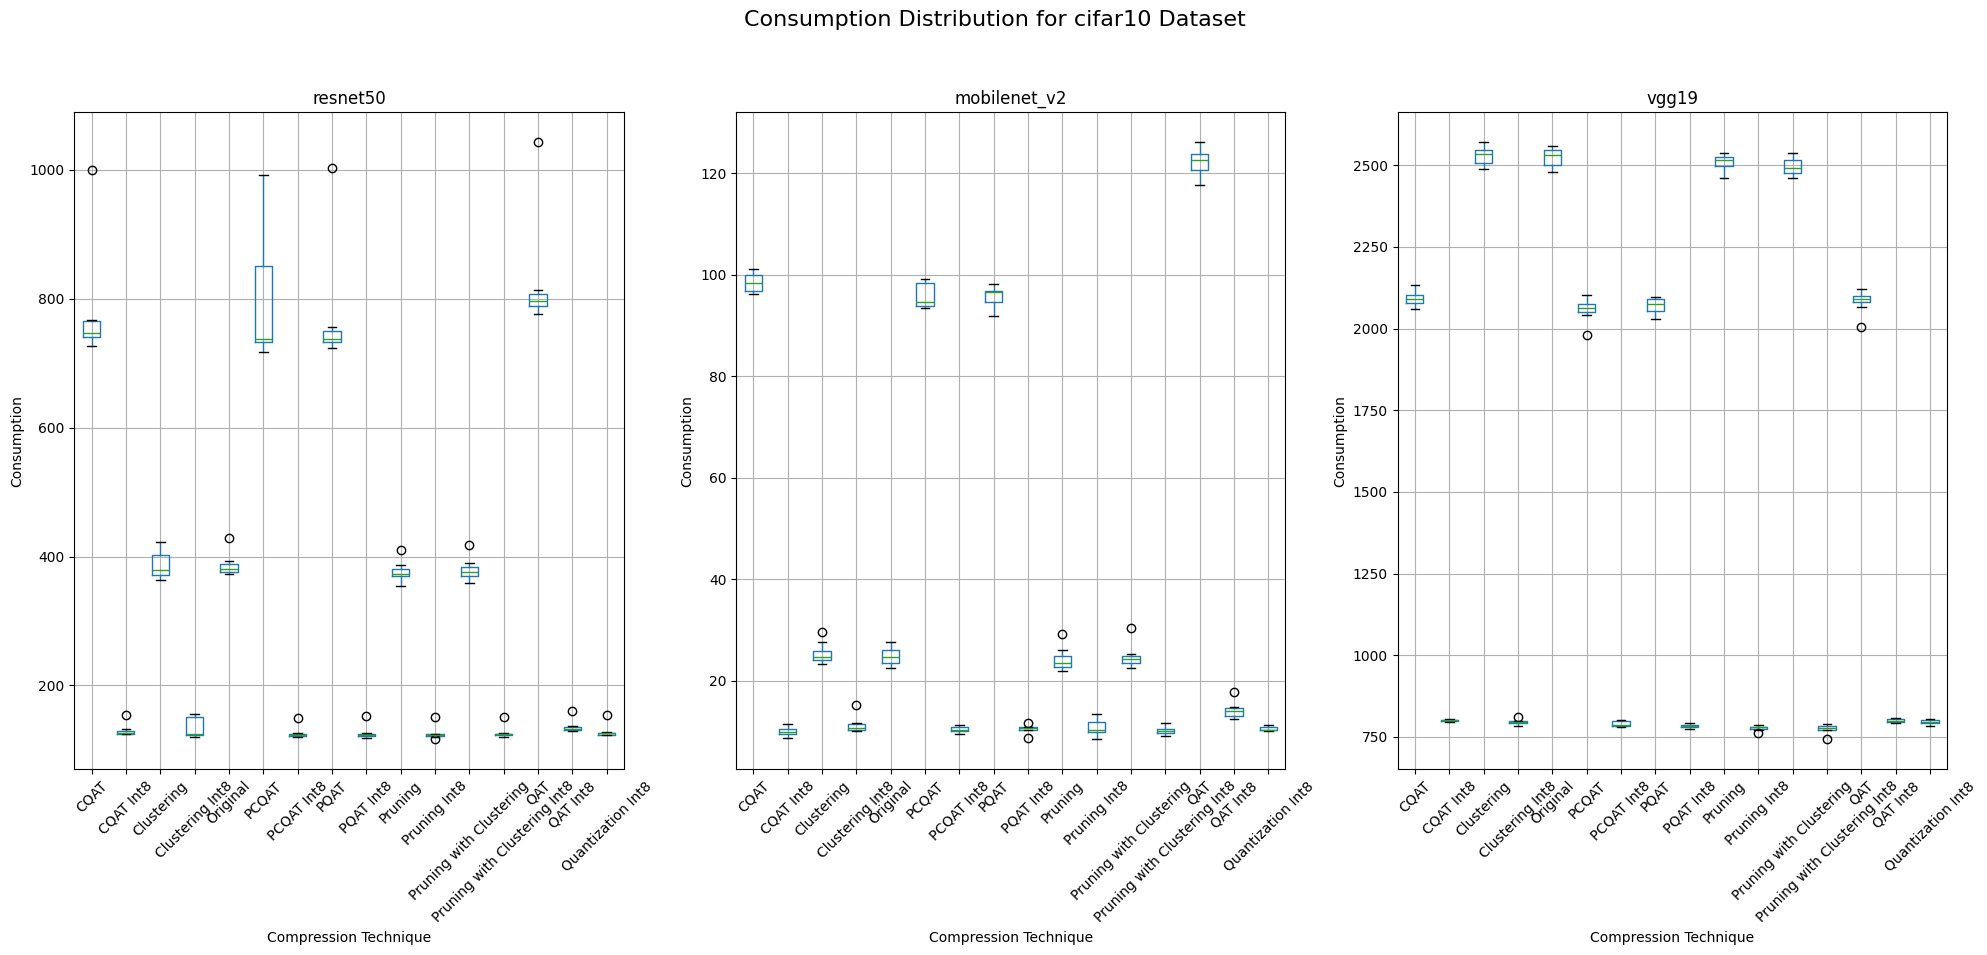

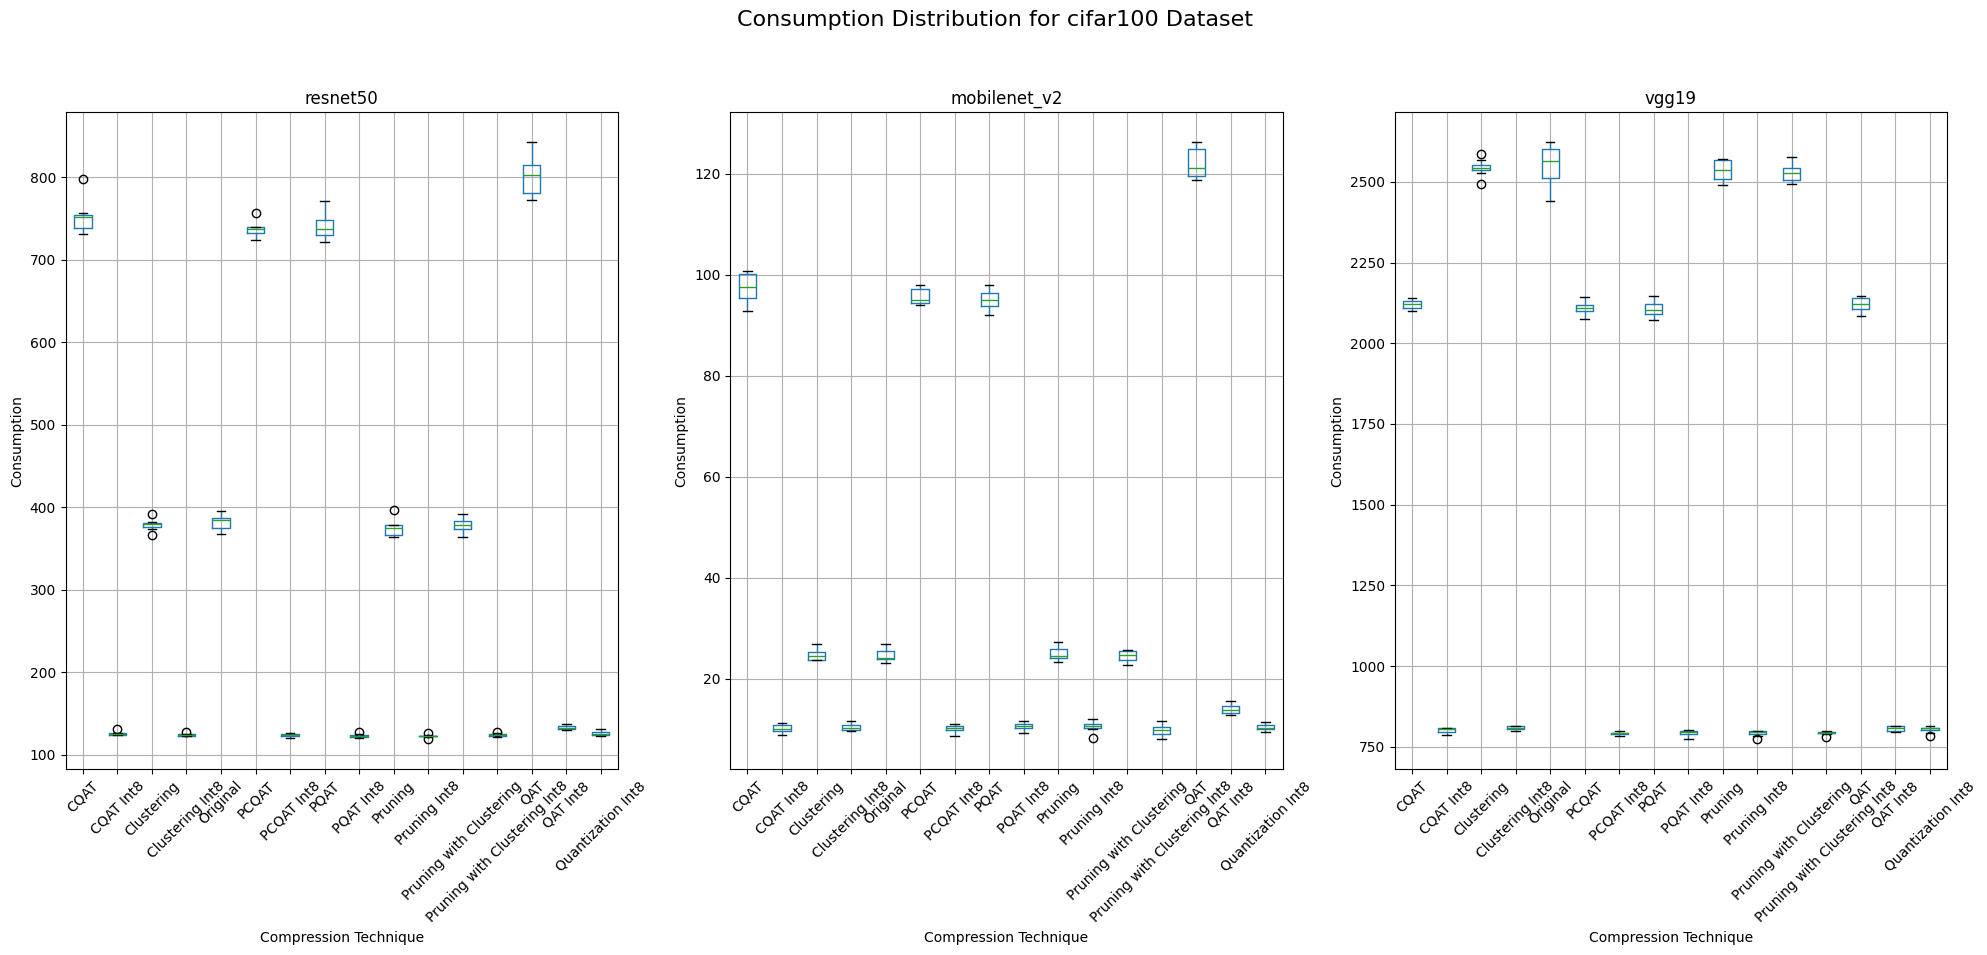

In [ ]:
for dataset in ['cifar10', 'cifar100']:
  fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 10))
  fig.suptitle('Consumption Distribution for Cifar10 Dataset', fontsize=16)
  for i, model in enumerate(models):
      df_cifar10 = df_melted[(df_melted['Model'] == model) & (df_melted['Dataset'] == dataset)]
      df_cifar10.boxplot(column='Consumption', by='Type', ax=axes[i], rot=45)
      axes[i].set_title(model)
      axes[i].set_ylabel('Consumption')
      axes[i].set_xlabel('Compression Technique')
      axes[i].get_figure().suptitle(f'Consumption Distribution for {dataset} Dataset', fontsize=16)

  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
  plt.show()

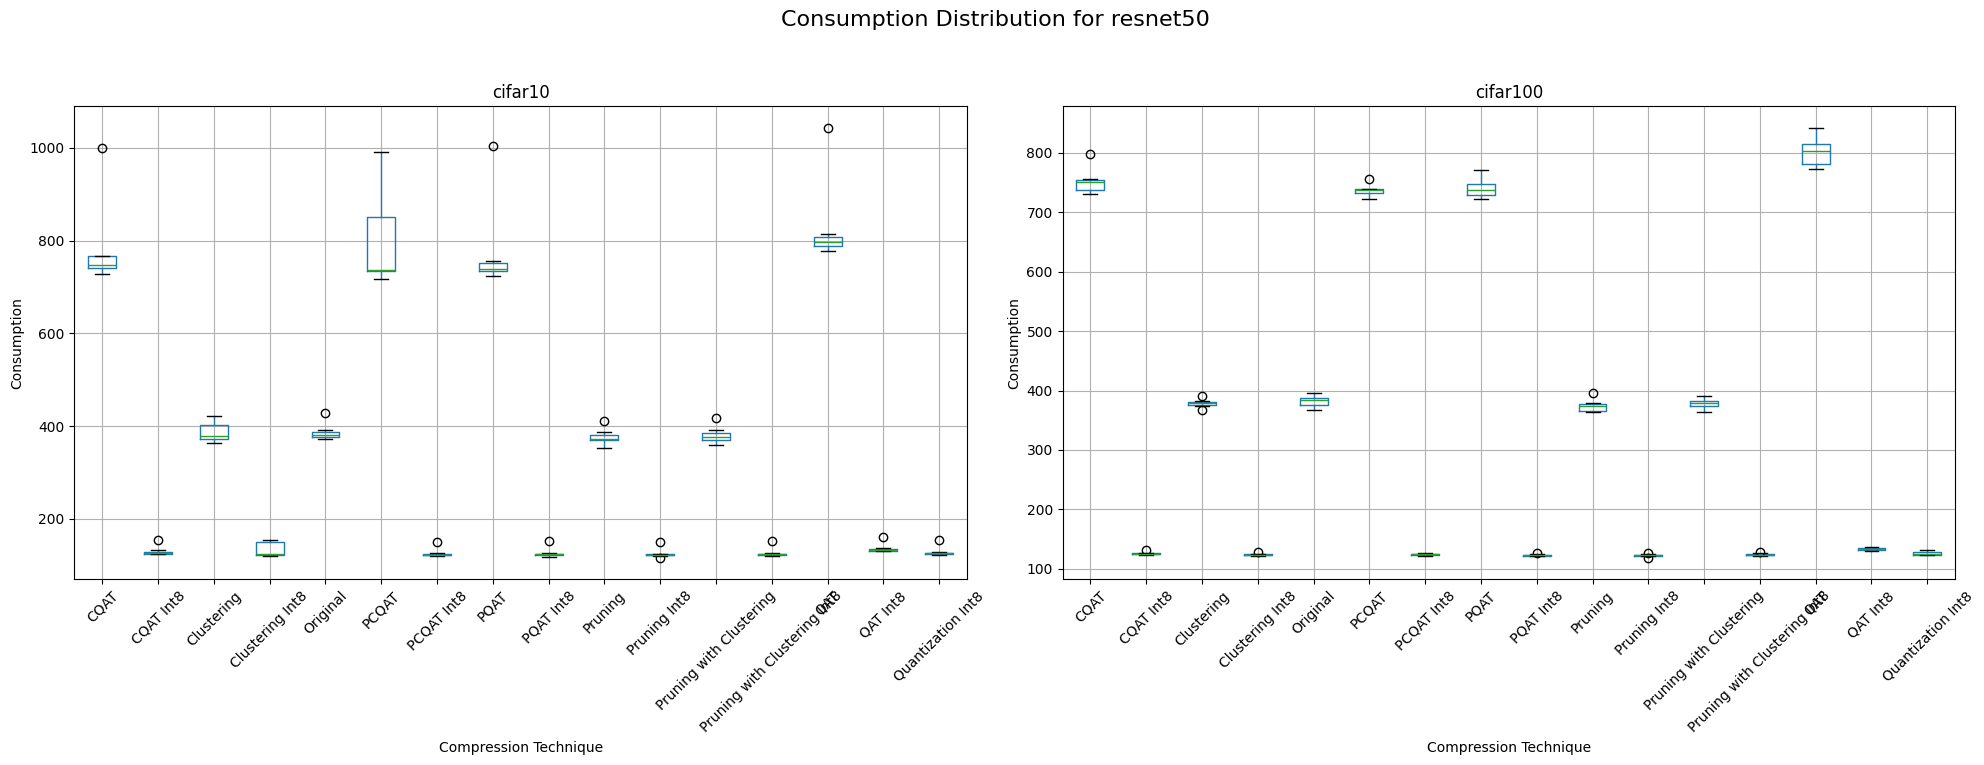

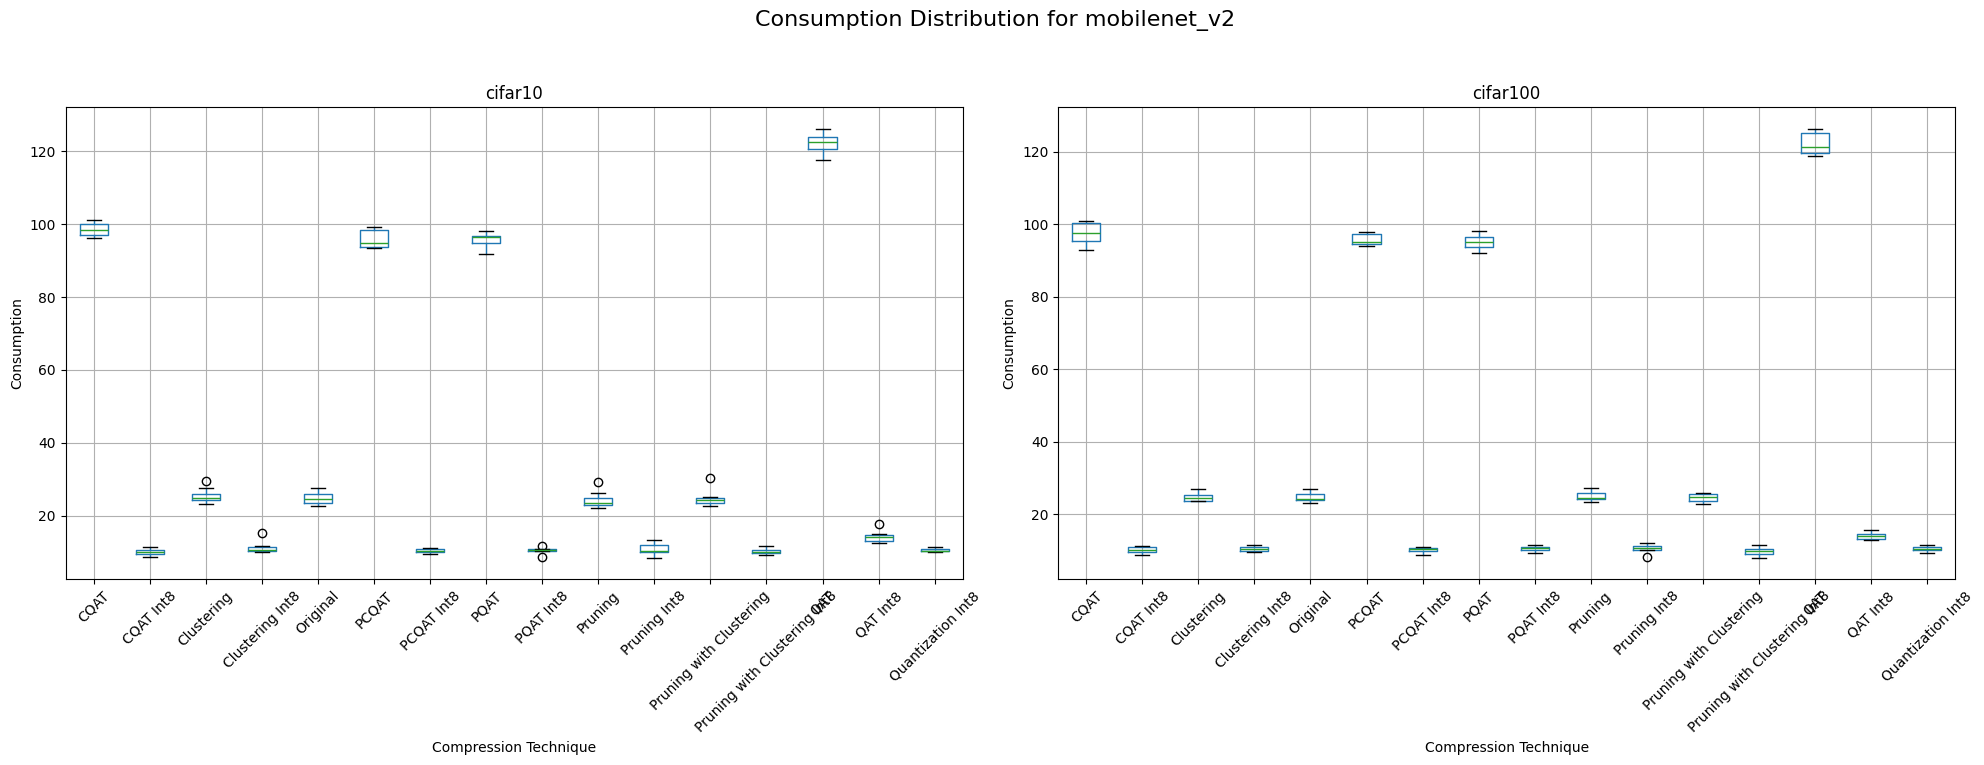

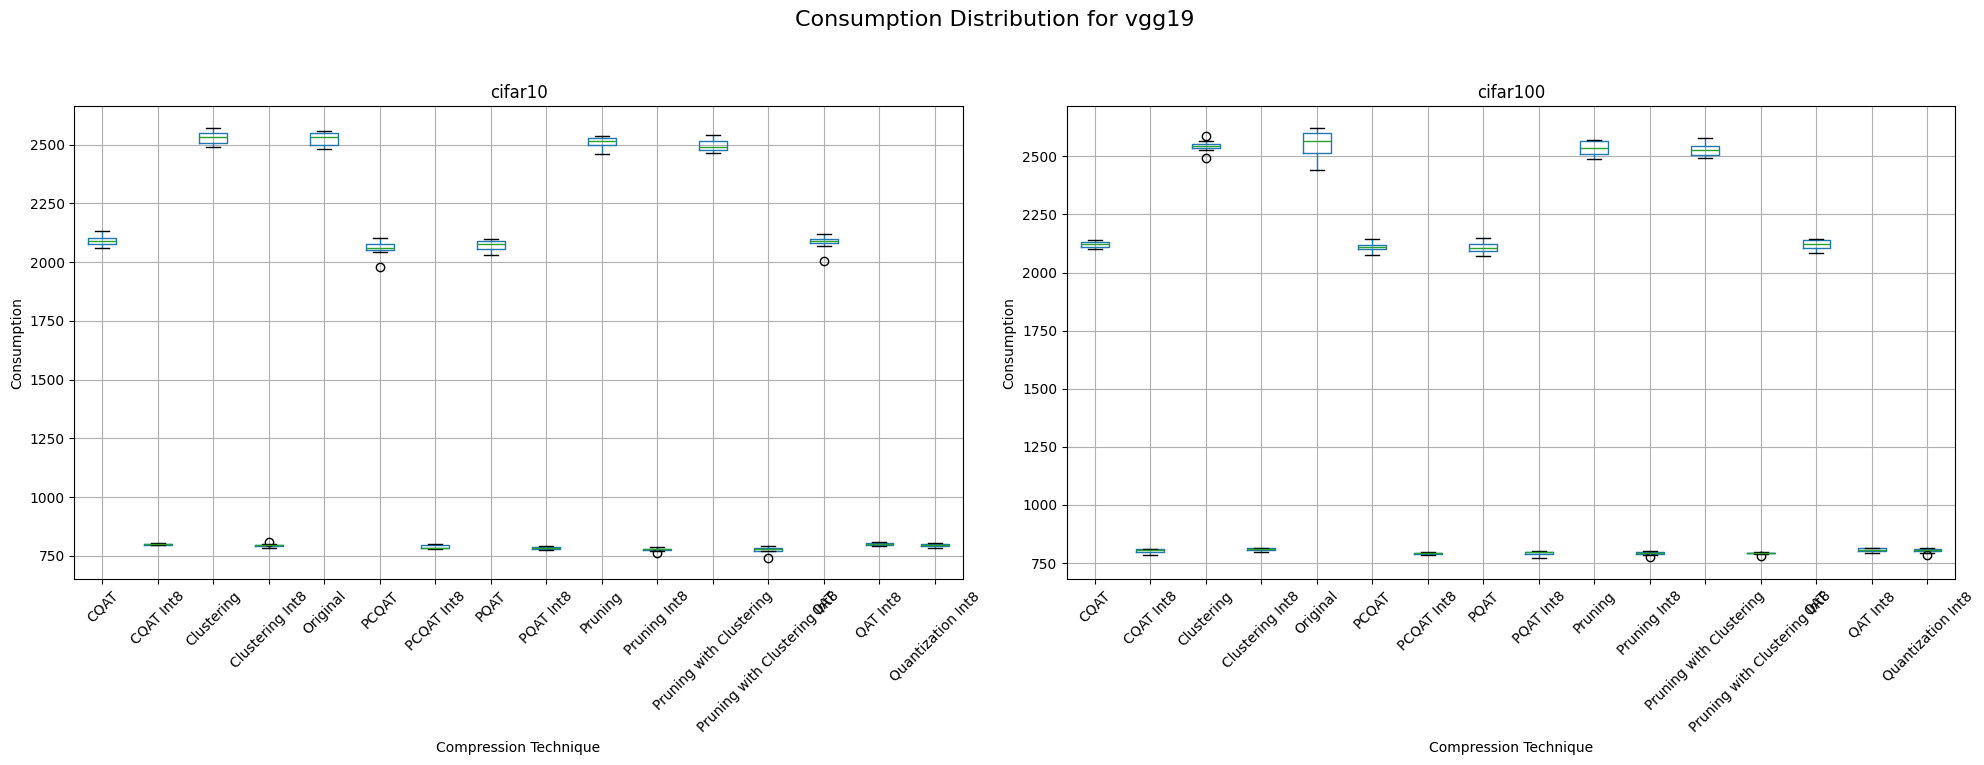

In [ ]:
for model in df_melted['Model'].unique():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    # fig.suptitle()

    # Plot for cifar10
    df_cifar10 = df_melted[(df_melted['Model'] == model) & (df_melted['Dataset'] == 'cifar10')]
    df_cifar10.boxplot(column='Consumption', by='Type', ax=axes[0], rot=45)
    axes[0].set_title('cifar10')
    axes[0].set_ylabel('Consumption')
    axes[0].set_xlabel('Compression Technique')

    # Plot for cifar100
    df_cifar100 = df_melted[(df_melted['Model'] == model) & (df_melted['Dataset'] == 'cifar100')]
    df_cifar100.boxplot(column='Consumption', by='Type', ax=axes[1], rot=45)
    axes[1].set_title('cifar100')
    axes[1].set_ylabel('Consumption')
    axes[1].set_xlabel('Compression Technique')

    axes[1].get_figure().suptitle(f'Consumption Distribution for {model}', fontsize=16) # Suppress the default suptitle

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

## Describe

In [ ]:
df_melted[df_melted['Dataset'] == 'cifar10'].groupby(['Model', 'Type'])['Consumption'].describe()

count         mean        std  \
Model        Type                                                          
mobilenet_v2 CQAT                            8.0    98.495328   1.853303   
             CQAT Int8                       8.0    10.000961   0.928435   
             Clustering                      8.0    25.436535   2.117943   
             Clustering Int8                 8.0    11.285568   1.694514   
             Original                        8.0    24.908606   1.916779   
             PCQAT                           8.0    95.810445   2.429701   
             PCQAT Int8                      8.0    10.425766   0.554099   
             PQAT                            8.0    95.703459   2.007411   
             PQAT Int8                       8.0    10.523400   0.846934   
             Pruning                         8.0    24.276769   2.430027   
             Pruning Int8                    8.0    10.819816   1.640883   
             Pruning with Clustering         8.0    24.827376   2.443748   
             Pruning with Clustering Int8    8.0    10.166612   0.807102   
             QAT                             8.0   122.064579   2.983796   
             QAT Int8                        8.0    14.236734   1.673283   
             Quantization Int8               8.0    10.541698   0.491968   
resnet50     CQAT                            8.0   778.622244  90.342887   
             CQAT Int8                       8.0   130.266710   9.879145   
             Clustering                      8.0   387.795772  22.503215   
             Clustering Int8                 8.0   133.968245  15.679318   
             Original                        8.0   386.458831  18.053825   
             PCQAT                           8.0   793.980321  97.703366   
             PCQAT Int8                      8.0   125.683039   9.679796   
             PQAT                            8.0   771.690576  94.233342   
             PQAT Int8                       8.0   126.444935  10.782952   
             Pruning                         8.0   376.095278  16.955494   
             Pruning Int8                    8.0   125.421036  10.618129   
             Pruning with Clustering         8.0   380.098491  18.160620   
             Pruning with Clustering Int8    8.0   126.982251  10.229368   
             QAT                             8.0   825.944011  88.506929   
             QAT Int8                        8.0   136.351981   9.954500   
             Quantization Int8               8.0   128.733064  10.579613   
vgg19        CQAT                            8.0  2092.075183  23.471014   
             CQAT Int8                       8.0   800.236351   4.019114   
             Clustering                      8.0  2529.712143  27.500025   
             Clustering Int8                 8.0   794.943208   7.680832   
             Original                        8.0  2524.690979  28.899562   
             PCQAT                           8.0  2057.699756  37.576658   
             PCQAT Int8                      8.0   789.099089   8.419394   
             PQAT                            8.0  2070.019288  26.168803   
             PQAT Int8                       8.0   782.669911   5.384164   
             Pruning                         8.0  2508.114139  26.799778   
             Pruning Int8                    8.0   776.373661   7.694882   
             Pruning with Clustering         8.0  2496.885105  27.726151   
             Pruning with Clustering Int8    8.0   774.797444  14.653529   
             QAT                             8.0  2083.372851  35.575154   
             QAT Int8                        8.0   799.482241   6.110738   
             Quantization Int8               8.0   795.994388   6.334178   

                                                   min          25%  \
Model        Type                                                     
mobilenet_v2 CQAT                            96.310811    96.893668   
             CQAT Int8       

## Export Consumption Rank

In [ ]:
df_consumption_cifar10 = df_melted[df_melted['Dataset'] == 'cifar10'].groupby(['Model', 'Type'])['Consumption'].quantile(0.9).groupby('Model', group_keys=False).apply(lambda x: x.sort_values())
df_consumption_cifar100 = df_melted[df_melted['Dataset'] == 'cifar100'].groupby(['Model', 'Type'])['Consumption'].quantile(0.9).groupby('Model', group_keys=False).apply(lambda x: x.sort_values())

In [ ]:
df_consumption_cifar10

Model         Type                        
mobilenet_v2  CQAT Int8                         10.938833
              Pruning with Clustering Int8      10.955166
              PCQAT Int8                        10.967515
              PQAT Int8                         11.141440
              Quantization Int8                 11.262744
              Clustering Int8                   12.748141
              Pruning Int8                      12.933301
              QAT Int8                          15.777174
              Pruning with Clustering           26.815197
              Pruning                           27.066340
              Original                          27.504888
              Clustering                        28.237927
              PQAT                              97.185122
              PCQAT                             98.702367
              CQAT                             100.374540
              QAT                              124.650473
resnet50      Pruning Int8                     132.237035
              PCQAT Int8                       132.530092
              PQAT Int8                        133.806828
              Pruning with Clustering Int8     134.021604
              Quantization Int8                136.134595
              CQAT Int8                        139.020196
              QAT Int8                         144.101732
              Clustering Int8                  153.853340
              Pruning                          394.229473
              Pruning with Clustering          398.957898
              Original                         403.177231
              Clustering                       418.350629
              PQAT                             830.196322
              CQAT                             836.748311
              QAT                              882.920764
              PCQAT                            899.371316
vgg19         Pruning Int8                     783.035786
              Pruning with Clustering Int8     786.974541
              PQAT Int8                        787.543468
              PCQAT Int8                       800.131891
              Quantization Int8                801.601077
              Clustering Int8                  802.331987
              CQAT Int8                        805.862487
              QAT Int8                         806.466335
              PCQAT                           2095.963123
              PQAT                            2096.429034
              QAT                             2115.749809
              CQAT                            2119.475568
              Pruning                         2531.989208
              Pruning with Clustering         2533.281648
              Original                        2553.295271
              Clustering                      2556.527366
Name: Consumption, dtype: float64

In [ ]:
print(df_consumption_cifar10)

Model         Type                        
mobilenet_v2  CQAT Int8                         10.938833
              Pruning with Clustering Int8      10.955166
              PCQAT Int8                        10.967515
              PQAT Int8                         11.141440
              Quantization Int8                 11.262744
              Clustering Int8                   12.748141
              Pruning Int8                      12.933301
              QAT Int8                          15.777174
              Pruning with Clustering           26.815197
              Pruning                           27.066340
              Original                          27.504888
              Clustering                        28.237927
              PQAT                              97.185122
              PCQAT                             98.702367
              CQAT                             100.374540
              QAT                              124.650473
resnet50      Pruning Int8   

In [ ]:
df_consumption_cifar10.groupby(level="Type").agg(['mean', 'std'])

,mean,std
Type,,
CQAT,1018.866140,1021.796172
CQAT Int8,318.607172,426.807352
Clustering,1001.038641,1361.141382
Clustering Int8,322.977823,421.085479
Original,994.659130,1362.825151
PCQAT,1031.345602,1005.149512
PCQAT Int8,314.543166,424.901956
PQAT,1007.936826,1011.403885
PQAT Int8,310.830579,417.376429


In [ ]:
# Export
df_consumption_cifar10.to_excel('consumption_cifar10.xlsx')
df_consumption_cifar100.to_excel('consumption_cifar100.xlsx')

## Final df_consumption with 0.9 quantile

In [ ]:
df_p90 = df_melted.groupby(['Model', 'Dataset', 'Type'])['Consumption'].quantile(0.9).reset_index()

In [ ]:
df_p90

,Model,Dataset,Type,Consumption
0,mobilenet_v2,cifar10,CQAT,100.374540
1,mobilenet_v2,cifar10,CQAT Int8,10.938833
2,mobilenet_v2,cifar10,Clustering,28.237927
3,mobilenet_v2,cifar10,Clustering Int8,12.748141
4,mobilenet_v2,cifar10,Original,27.504888
...,...,...,...,...
91,vgg19,cifar100,Pruning with Clustering,2554.658954
92,vgg19,cifar100,Pruning with Clustering Int8,796.449538
93,vgg19,cifar100,QAT,2144.598184
94,vgg19,cifar100,QAT Int8,813.999431


In [ ]:
baseline_p90 = df_p90[df_p90['Type'] == 'Original'].set_index(['Model', 'Dataset'])['Consumption']
baseline_p90

Model         Dataset 
mobilenet_v2  cifar10       27.504888
              cifar100      26.924706
resnet50      cifar10      403.177231
              cifar100     390.592906
vgg19         cifar10     2553.295271
              cifar100    2609.762783
Name: Consumption, dtype: float64

In [ ]:
df_p90 = df_p90.set_index(['Model', 'Dataset'])

df_p90['Baseline_Consumption'] = baseline_p90

df_p90 = df_p90.reset_index()

df_p90

,Model,Dataset,Type,Consumption,Baseline_Consumption
0,mobilenet_v2,cifar10,CQAT,100.374540,27.504888
1,mobilenet_v2,cifar10,CQAT Int8,10.938833,27.504888
2,mobilenet_v2,cifar10,Clustering,28.237927,27.504888
3,mobilenet_v2,cifar10,Clustering Int8,12.748141,27.504888
4,mobilenet_v2,cifar10,Original,27.504888,27.504888
...,...,...,...,...,...
91,vgg19,cifar100,Pruning with Clustering,2554.658954,2609.762783
92,vgg19,cifar100,Pruning with Clustering Int8,796.449538,2609.762783
93,vgg19,cifar100,QAT,2144.598184,2609.762783
94,vgg19,cifar100,QAT Int8,813.999431,2609.762783


In [ ]:
df_p90['Normalized_Consumption'] = df_p90['Baseline_Consumption'] / df_p90['Consumption']

df_p90

,Model,Dataset,Type,Consumption,Baseline_Consumption,Normalized_Consumption
0,mobilenet_v2,cifar10,CQAT,100.374540,27.504888,0.274023
1,mobilenet_v2,cifar10,CQAT Int8,10.938833,27.504888,2.514426
2,mobilenet_v2,cifar10,Clustering,28.237927,27.504888,0.974041
3,mobilenet_v2,cifar10,Clustering Int8,12.748141,27.504888,2.157561
4,mobilenet_v2,cifar10,Original,27.504888,27.504888,1.000000
...,...,...,...,...,...,...
91,vgg19,cifar100,Pruning with Clustering,2554.658954,2609.762783,1.021570
92,vgg19,cifar100,Pruning with Clustering Int8,796.449538,2609.762783,3.276746
93,vgg19,cifar100,QAT,2144.598184,2609.762783,1.216901
94,vgg19,cifar100,QAT Int8,813.999431,2609.762783,3.206099


In [ ]:
df_p90.groupby(['Dataset', 'Type'])['Normalized_Consumption'].agg(['mean', 'std'])

mean       std
Dataset  Type                                            
cifar10  CQAT                          0.653514  0.488504
         CQAT Int8                     2.860987  0.328740
         Clustering                    0.978836  0.017989
         Clustering Int8               2.653478  0.513185
         Original                      1.000000  0.000000
         PCQAT                         0.648383  0.500708
         PCQAT Int8                    2.913700  0.359278
         PQAT                          0.662194  0.491826
         PQAT Int8                     2.907977  0.397277
         Pruning                       1.015771  0.007151
         Pruning Int8                  2.812111  0.602986
         Pruning with Clustering       1.014732  0.009610
         Pruning with Clustering Int8  2.921141  0.374568
         QAT                           0.628033  0.514931
         QAT Int8                      2.569076  0.738426
         Quantization Int8             2.862988  0.381255
cifar100 CQAT                          0.665516  0.496413
         CQAT Int8                     2.906706  0.412646
         Clustering                    1.016434  0.003009
         Clustering Int8               2.896407  0.442031
         Original                      1.000000  0.000000
         PCQAT                         0.674843  0.491989
         PCQAT Int8                    2.949992  0.430007
         PQAT                          0.669441  0.490877
         PQAT Int8                     2.917437  0.470273
         Pruning                       1.017644  0.001902
         Pruning Int8                  2.899137  0.521434
         Pruning with Clustering       1.022885  0.020919
         Pruning with Clustering Int8  2.894939  0.498328
         QAT                           0.634611  0.520556
         QAT Int8                      2.599811  0.775365
         Quantization Int8             2.871210  0.417531

In [ ]:
print(df_p90.groupby(['Dataset', 'Type'])['Normalized_Consumption'].agg(['mean', 'std']))

                                           mean       std
Dataset  Type                                            
cifar10  CQAT                          0.653514  0.488504
         CQAT Int8                     2.860987  0.328740
         Clustering                    0.978836  0.017989
         Clustering Int8               2.653478  0.513185
         Original                      1.000000  0.000000
         PCQAT                         0.648383  0.500708
         PCQAT Int8                    2.913700  0.359278
         PQAT                          0.662194  0.491826
         PQAT Int8                     2.907977  0.397277
         Pruning                       1.015771  0.007151
         Pruning Int8                  2.812111  0.602986
         Pruning with Clustering       1.014732  0.009610
         Pruning with Clustering Int8  2.921141  0.374568
         QAT                           0.628033  0.514931
         QAT Int8                      2.569076  0.738426
         Quant

In [ ]:
df_consumption = df_p90.set_index(['Model', 'Dataset', 'Type'])[["Normalized_Consumption"]]

df_consumption = df_consumption.rename(columns={'Normalized_Consumption': 'Consumption'})

# Latency

In [ ]:
models = ['resnet50', 'mobilenet_v2', 'vgg19']
latencies = {
    "Original": 'latency_{model_name}.json',
    'Quantization Int8': 'latency_{model_name}_full_integer.json',
    'Pruning': 'latency_{model_name}_pruning_50.json',
    'Pruning Int8': 'latency_{model_name}_pruning_50_full_integer.json',
    'Clustering': 'latency_{model_name}_clustering_16.json',
    'Clustering Int8': 'latency_{model_name}_clustering_16_full_integer.json',
    'Pruning with Clustering': 'latency_{model_name}_pruning_50_clustering_16.json',
    'Pruning with Clustering Int8': 'latency_{model_name}_pruning_50_clustering_16_full_integer.json',
    'QAT':'latency_{model_name}_qat.json',
    'QAT Int8': 'latency_{model_name}_qat_full_integer.json',
    'CQAT': 'latency_{model_name}_clustering_16_qat.json',
    'CQAT Int8': 'latency_{model_name}_clustering_16_qat_full_integer.json',
    'PQAT': 'latency_{model_name}_pruning_50_qat.json',
    'PQAT Int8': 'latency_{model_name}_pruning_50_qat_full_integer.json',
    'PCQAT': 'latency_{model_name}_pruning_50_clustering_16_qat.json',
    'PCQAT Int8': 'latency_{model_name}_pruning_50_clustering_16_qat_full_integer.json',
}

In [ ]:
all_latencies = {}
for model in models:
    all_latencies[model] = {}
    for dataset in ['cifar10', 'cifar100']:
        all_latencies[model][dataset] = {}
        for key, value in latencies.items():
            file_name = value.format(model_name=model)
            result = load_json(f'{BASE_PATH}/{dataset}/optimization/{model}/latencies/{file_name}')
            all_latencies[model][dataset][key] = result

File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded 

In [ ]:
data_for_df = []
for model, datasets in all_latencies.items():
    for dataset, keys in datasets.items():
        for key, value in keys.items():
            data_for_df.append({'Model': model, 'Dataset': dataset, 'Type': key, 'Latency': value[24:1024]})

df_latencies = pd.DataFrame(data_for_df)
df_latencies = df_latencies.set_index(['Model', 'Dataset', 'Type'])

In [ ]:
df_latencies

Latency
Model    Dataset  Type                                                                
resnet50 cifar10  Original           [0.5360088130000804, 0.534761012000672, 0.5342...
                  Quantization Int8  [0.15585315200041805, 0.16011239600084082, 0.1...
                  Pruning            [0.5791494450004393, 0.5832763609996618, 0.581...
                  Pruning Int8       [0.17457928699877812, 0.1743471000008867, 0.17...
                  Clustering         [0.5172788010004297, 0.5183820700003707, 0.515...
...                                                                                ...
vgg19    cifar100 CQAT Int8          [1.1444785589992534, 1.123072696995223, 1.1330...
                  PQAT               [3.2263712139993004, 3.356618891000835, 3.2816...
                  PQAT Int8          [2.096058860999989, 1.0298490999999785, 1.6508...
                  PCQAT              [3.337359072000254, 3.38030208499913, 3.322145...
                  PCQAT Int8         [1.0382938590046251, 1.042099407997739, 1.0401...

[96 rows x 1 columns]

In [ ]:
df_latencies_reset = df_latencies.reset_index()

melted_latencies = []
for index, row in df_latencies_reset.iterrows():
    model = row['Model']
    dataset = row['Dataset']
    key = row['Type']
    latencies = row['Latency']
    for latency in latencies:
        melted_latencies.append({'Model': model, 'Dataset': dataset, 'Type': key, 'Latency': latency})

df_melted = pd.DataFrame(melted_latencies)

In [ ]:
df_melted

,Model,Dataset,Type,Latency
0,resnet50,cifar10,Original,0.536009
1,resnet50,cifar10,Original,0.534761
2,resnet50,cifar10,Original,0.534253
3,resnet50,cifar10,Original,0.539813
4,resnet50,cifar10,Original,0.535230
...,...,...,...,...
95995,vgg19,cifar100,PCQAT Int8,1.041087
95996,vgg19,cifar100,PCQAT Int8,1.042799
95997,vgg19,cifar100,PCQAT Int8,1.042509
95998,vgg19,cifar100,PCQAT Int8,1.046307


## Boxplot
**Reasoning**:
Iterate through each model and dataset, create a figure with two subplots (one for each dataset), and generate box plots for each key within the respective dataset for that model.



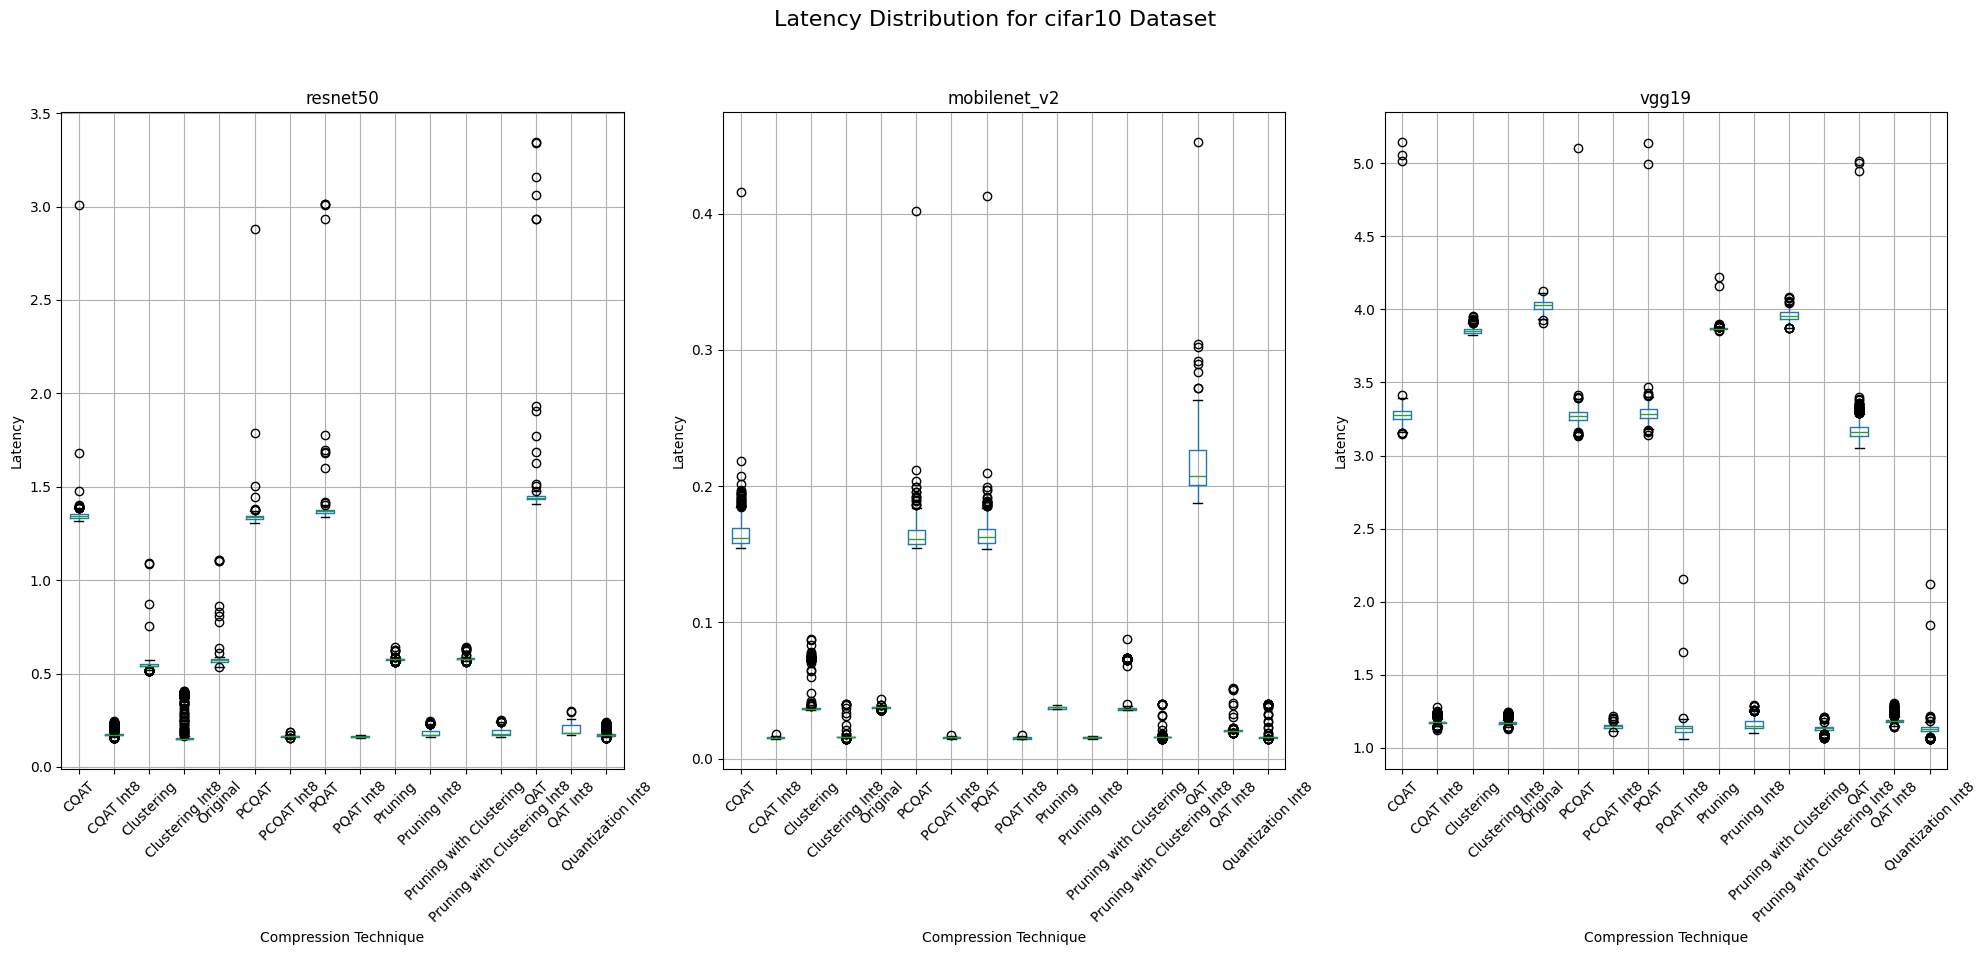

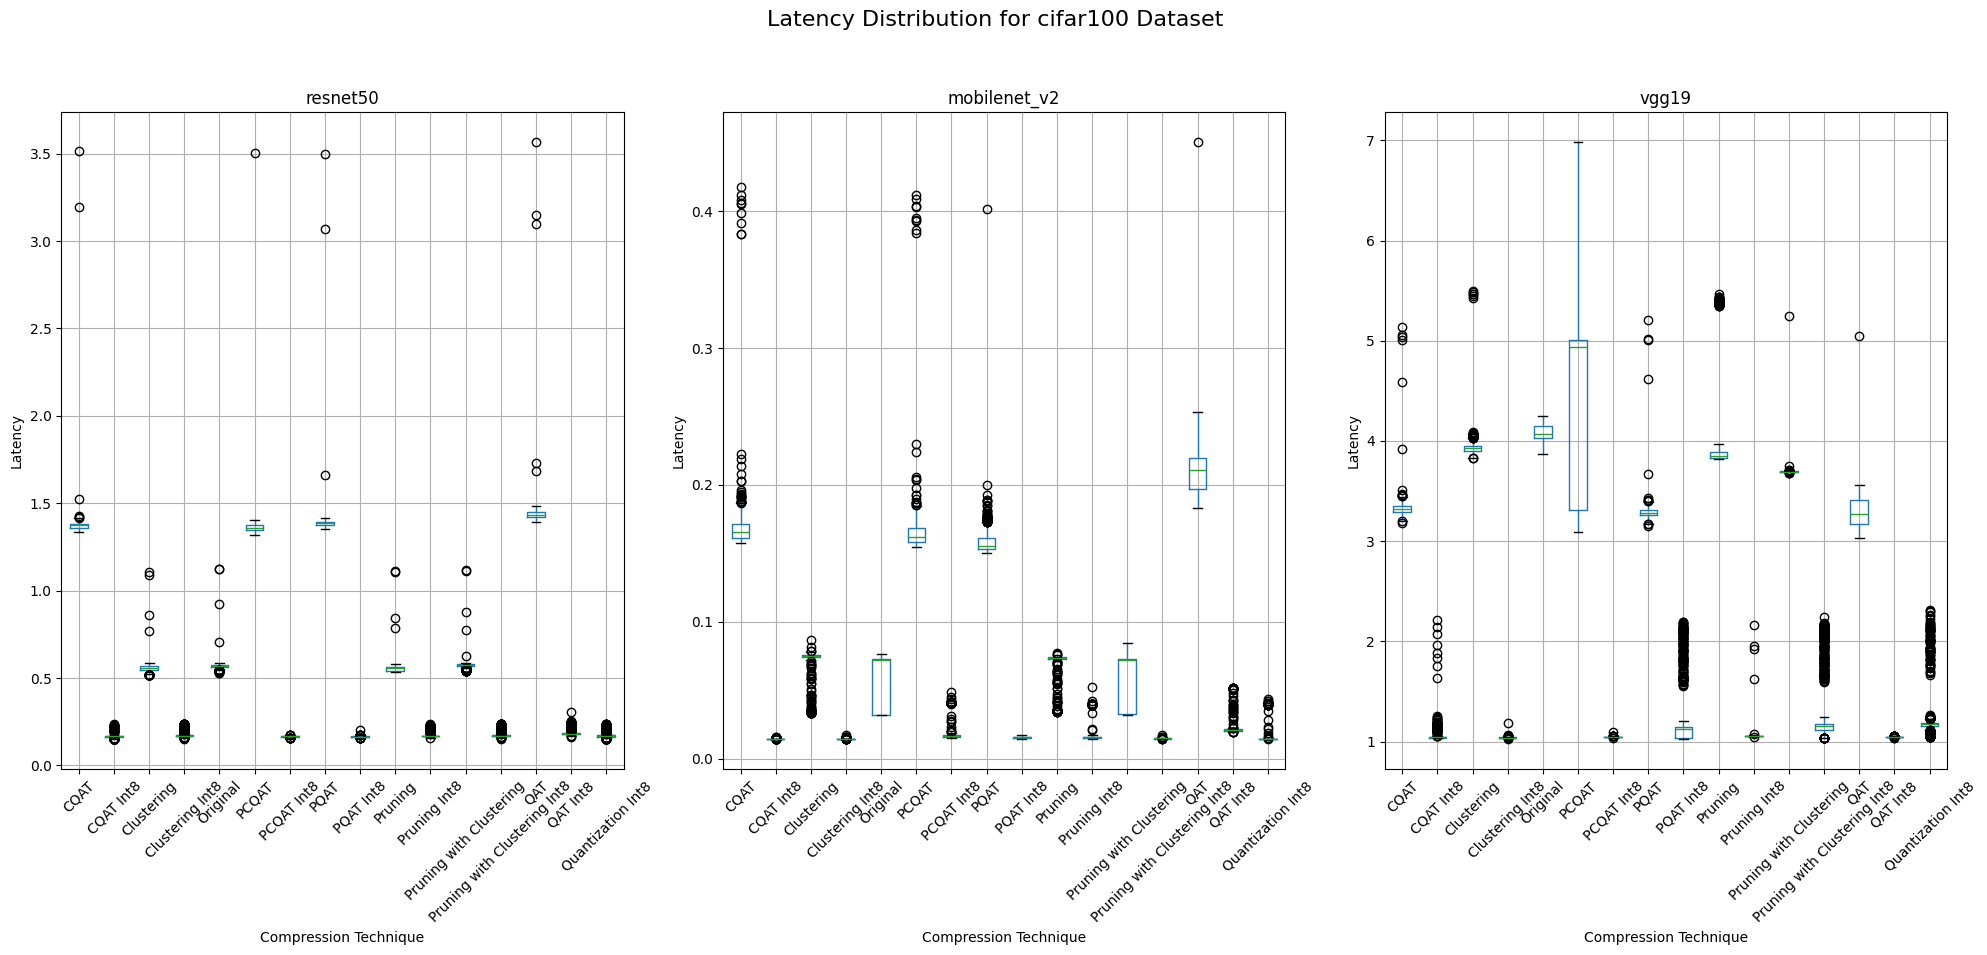

In [ ]:
for dataset in ['cifar10', 'cifar100']:
  fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 10))
  fig.suptitle('Latency Distribution for Cifar10 Dataset', fontsize=16)
  for i, model in enumerate(models):
      df_cifar10 = df_melted[(df_melted['Model'] == model) & (df_melted['Dataset'] == dataset)]
      df_cifar10.boxplot(column='Latency', by='Type', ax=axes[i], rot=45)
      axes[i].set_title(model)
      axes[i].set_ylabel('Latency')
      axes[i].set_xlabel('Compression Technique')
      axes[i].get_figure().suptitle(f'Latency Distribution for {dataset} Dataset', fontsize=16)

  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
  plt.show()

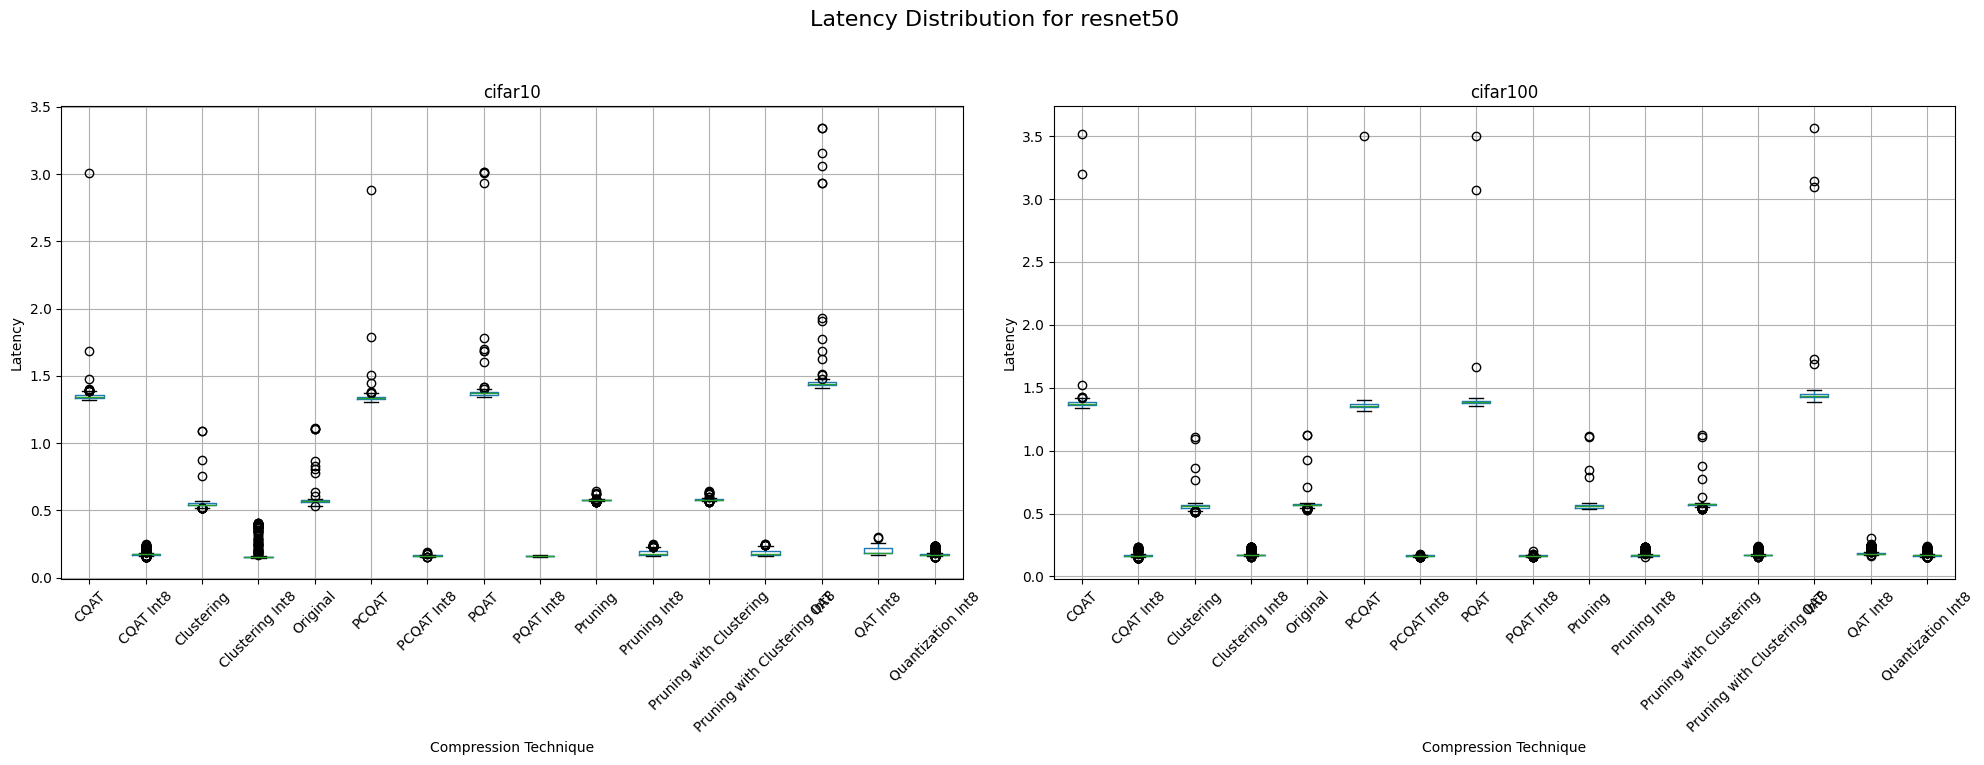

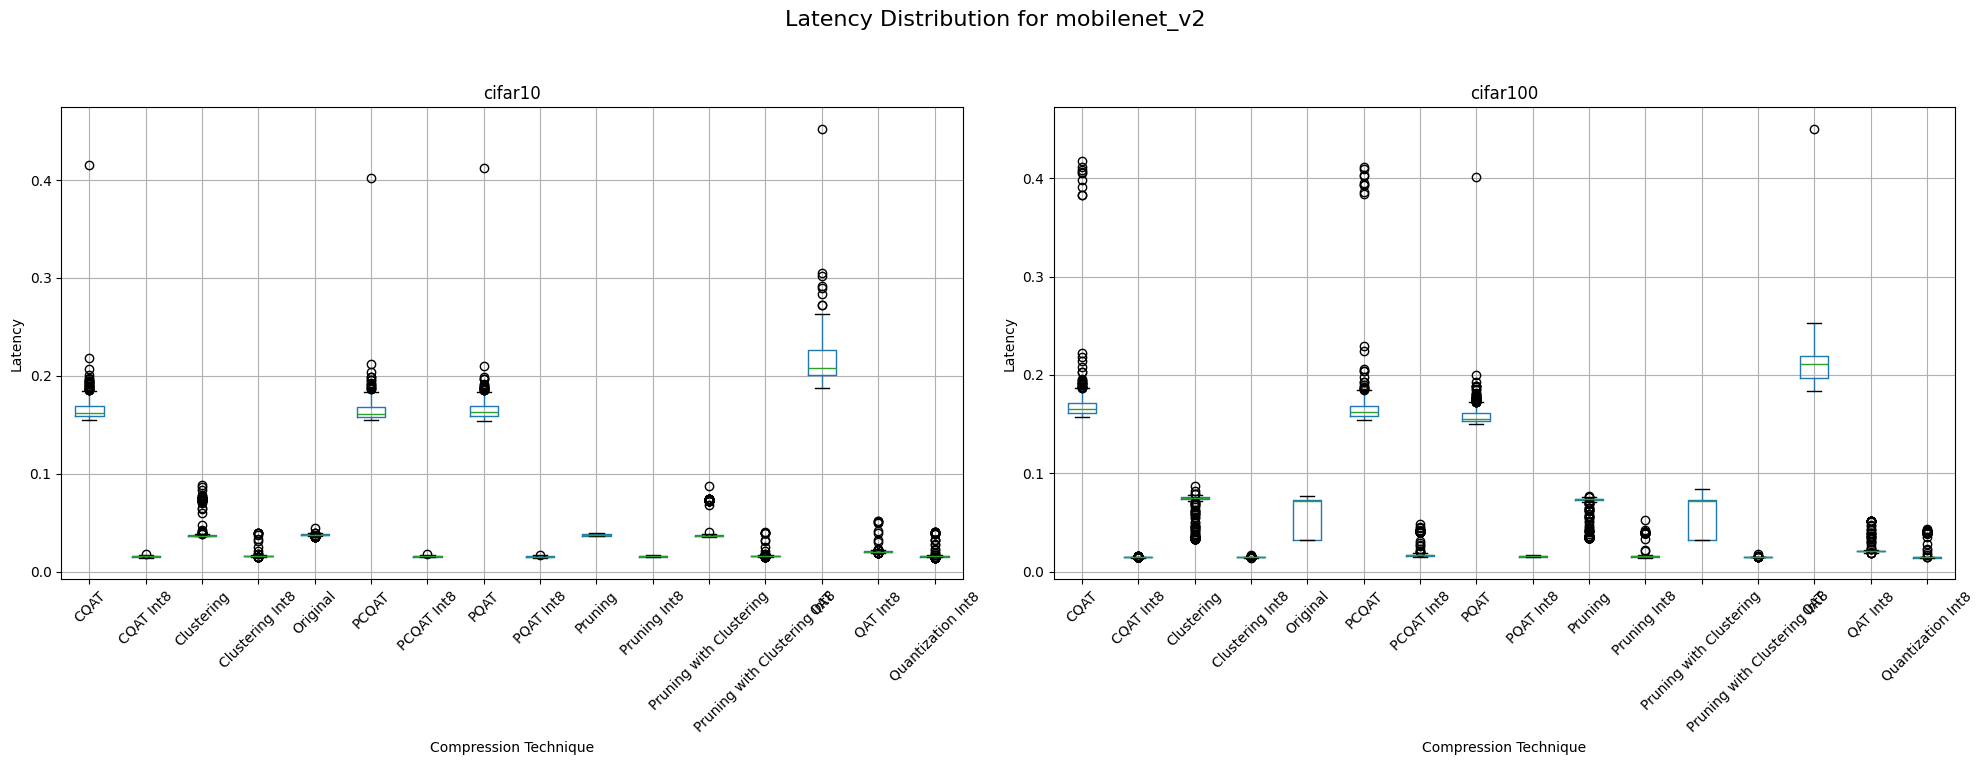

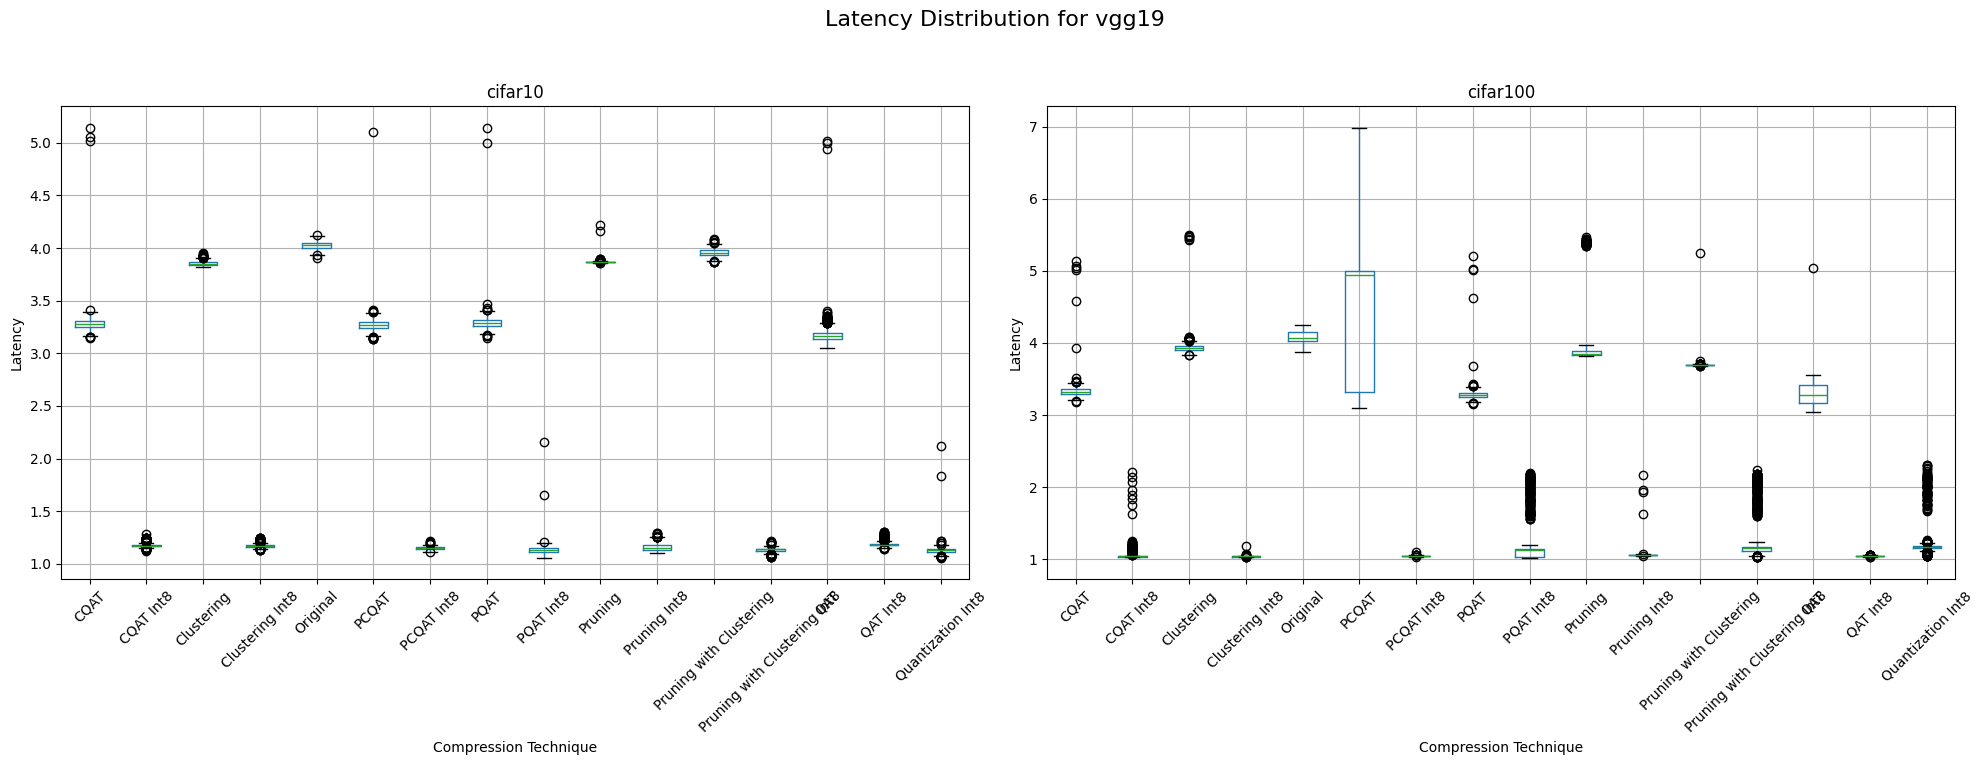

In [ ]:
for model in df_melted['Model'].unique():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    # fig.suptitle()

    # Plot for cifar10
    df_cifar10 = df_melted[(df_melted['Model'] == model) & (df_melted['Dataset'] == 'cifar10')]
    df_cifar10.boxplot(column='Latency', by='Type', ax=axes[0], rot=45)
    axes[0].set_title('cifar10')
    axes[0].set_ylabel('Latency')
    axes[0].set_xlabel('Compression Technique')

    # Plot for cifar100
    df_cifar100 = df_melted[(df_melted['Model'] == model) & (df_melted['Dataset'] == 'cifar100')]
    df_cifar100.boxplot(column='Latency', by='Type', ax=axes[1], rot=45)
    axes[1].set_title('cifar100')
    axes[1].set_ylabel('Latency')
    axes[1].set_xlabel('Compression Technique')

    axes[1].get_figure().suptitle(f'Latency Distribution for {model}', fontsize=16) # Suppress the default suptitle

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

## Describe

In [ ]:
df_melted[df_melted['Dataset'] == 'cifar10'].groupby(['Model', 'Type'])['Latency'].describe()

count      mean       std  \
Model        Type                                                       
mobilenet_v2 CQAT                          1000.0  0.164724  0.008185   
             CQAT Int8                     1000.0  0.015450  0.000604   
             Clustering                    1000.0  0.043188  0.014285   
             Clustering Int8               1000.0  0.016148  0.002025   
             Original                      1000.0  0.037579  0.000666   
             PCQAT                         1000.0  0.163780  0.008121   
             PCQAT Int8                    1000.0  0.015750  0.000455   
             PQAT                          1000.0  0.164626  0.007815   
             PQAT Int8                     1000.0  0.015180  0.000541   
             Pruning                       1000.0  0.037754  0.000769   
             Pruning Int8                  1000.0  0.015558  0.000513   
             Pruning with Clustering       1000.0  0.038216  0.007685   
             Pruning with Clustering Int8  1000.0  0.016191  0.002043   
             QAT                           1000.0  0.212925  0.015994   
             QAT Int8                      1000.0  0.020669  0.002261   
             Quantization Int8             1000.0  0.016094  0.002854   
resnet50     CQAT                          1000.0  1.347679  0.055655   
             CQAT Int8                     1000.0  0.177593  0.018116   
             Clustering                    1000.0  0.544227  0.010369   
             Clustering Int8               1000.0  0.195906  0.090859   
             Original                      1000.0  0.566618  0.012983   
             PCQAT                         1000.0  1.338016  0.052435   
             PCQAT Int8                    1000.0  0.163388  0.003045   
             PQAT                          1000.0  1.376620  0.105351   
             PQAT Int8                     1000.0  0.161065  0.003264   
             Pruning                       1000.0  0.576670  0.005192   
             Pruning Int8                  1000.0  0.183083  0.021751   
             Pruning with Clustering       1000.0  0.579007  0.005902   
             Pruning with Clustering Int8  1000.0  0.185558  0.022493   
             QAT                           1000.0  1.453317  0.133877   
             QAT Int8                      1000.0  0.198778  0.025301   
             Quantization Int8             1000.0  0.177004  0.018635   
vgg19        CQAT                          1000.0  3.278257  0.088913   
             CQAT Int8                     1000.0  1.175515  0.015553   
             Clustering                    1000.0  3.852970  0.020559   
             Clustering Int8               1000.0  1.172384  0.017484   
             Original                      1000.0  4.027221  0.034627   
             PCQAT                         1000.0  3.271644  0.041336   
             PCQAT Int8                    1000.0  1.147677  0.012850   
             PQAT                          1000.0  3.287801  0.068633   
             PQAT Int8                     1000.0  1.130875  0.043831   
             Pruning                       1000.0  3.868852  0.015311   
             Pruning Int8                  1000.0  1.158807  0.035454   
             Pruning with Clustering       1000.0  3.955278  0.030854   
             Pruning with Clustering Int8  1000.0  1.136175  0.015273   
             QAT                           1000.0  3.175118  0.097660   
             QAT Int8                      1000.0  1.191841  0.026934   
             Quantization Int8             1000.0  1.128129  0.043540   

                                                min       25%       50%  \
Model        Type                                                         
mobilenet_v2 CQAT                          0.154907  0.158435  0.162110   
             CQAT Int8                     0.014394  0.014952  0.015515   
             Clustering                    0.035955  0.036292  0.036414   
             Clust

In [ ]:
df_melted[df_melted['Dataset'] == 'cifar100'].groupby(['Model', 'Type'])['Latency'].describe()

count      mean       std  \
Model        Type                                                       
mobilenet_v2 CQAT                          1000.0  0.169269  0.022182   
             CQAT Int8                     1000.0  0.014481  0.000169   
             Clustering                    1000.0  0.069352  0.013999   
             Clustering Int8               1000.0  0.014469  0.000220   
             Original                      1000.0  0.059634  0.018605   
             PCQAT                         1000.0  0.166108  0.022299   
             PCQAT Int8                    1000.0  0.020228  0.009176   
             PQAT                          1000.0  0.158089  0.006866   
             PQAT Int8                     1000.0  0.015567  0.000641   
             Pruning                       1000.0  0.066522  0.014933   
             Pruning Int8                  1000.0  0.017380  0.006723   
             Pruning with Clustering       1000.0  0.058926  0.018900   
             Pruning with Clustering Int8  1000.0  0.014744  0.000118   
             QAT                           1000.0  0.209482  0.013782   
             QAT Int8                      1000.0  0.021614  0.004288   
             Quantization Int8             1000.0  0.019554  0.010276   
resnet50     CQAT                          1000.0  1.374232  0.059531   
             CQAT Int8                     1000.0  0.166353  0.008896   
             Clustering                    1000.0  0.558477  0.029791   
             Clustering Int8               1000.0  0.175091  0.015702   
             Original                      1000.0  0.570140  0.029410   
             PCQAT                         1000.0  1.359446  0.017733   
             PCQAT Int8                    1000.0  0.165893  0.002911   
             PQAT                          1000.0  1.386097  0.055233   
             PQAT Int8                     1000.0  0.165542  0.003202   
             Pruning                       1000.0  0.557310  0.030311   
             Pruning Int8                  1000.0  0.171004  0.012342   
             Pruning with Clustering       1000.0  0.574135  0.027883   
             Pruning with Clustering Int8  1000.0  0.176315  0.016057   
             QAT                           1000.0  1.439666  0.078642   
             QAT Int8                      1000.0  0.190840  0.021612   
             Quantization Int8             1000.0  0.169979  0.011524   
vgg19        CQAT                          1000.0  3.332191  0.113453   
             CQAT Int8                     1000.0  1.064526  0.091488   
             Clustering                    1000.0  3.938065  0.106520   
             Clustering Int8               1000.0  1.039570  0.005869   
             Original                      1000.0  4.071038  0.091213   
             PCQAT                         1000.0  4.292916  0.988174   
             PCQAT Int8                    1000.0  1.045156  0.003900   
             PQAT                          1000.0  3.288626  0.098077   
             PQAT Int8                     1000.0  1.187865  0.264235   
             Pruning                       1000.0  3.965705  0.391301   
             Pruning Int8                  1000.0  1.059345  0.056018   
             Pruning with Clustering       1000.0  3.695675  0.049261   
             Pruning with Clustering Int8  1000.0  1.239564  0.278716   
             QAT                           1000.0  3.289074  0.130907   
             QAT Int8                      1000.0  1.043166  0.003958   
             Quantization Int8             1000.0  1.225379  0.222290   

                                                min       25%       50%  \
Model        Type                                                         
mobilenet_v2 CQAT                          0.157337  0.161315  0.165564   
             CQAT Int8                     0.014263  0.014397  0.014437   
             Clustering                    0.033094  0.074170  0.074978   
             Clust

## Export Latency Rank

In [ ]:
df_latency_cifar10 = df_melted[df_melted['Dataset'] == 'cifar10'].groupby(['Model', 'Type'])['Latency'].quantile(0.9).groupby('Model', group_keys=False).apply(lambda x: x.sort_values())
df_latency_cifar100 = df_melted[df_melted['Dataset'] == 'cifar100'].groupby(['Model', 'Type'])['Latency'].quantile(0.9).groupby('Model', group_keys=False).apply(lambda x: x.sort_values())

In [ ]:
df_latency_cifar10

Model         Type                        
mobilenet_v2  PQAT Int8                       0.015908
              Pruning Int8                    0.016170
              CQAT Int8                       0.016280
              Quantization Int8               0.016323
              PCQAT Int8                      0.016406
              Clustering Int8                 0.016606
              Pruning with Clustering Int8    0.016611
              QAT Int8                        0.021252
              Pruning with Clustering         0.037858
              Original                        0.038268
              Pruning                         0.038598
              Clustering                      0.073379
              PQAT                            0.175688
              PCQAT                           0.176126
              CQAT                            0.176561
              QAT                             0.232837
resnet50      PQAT Int8                       0.165208
              PCQAT Int8                      0.166896
              CQAT Int8                       0.210289
              Quantization Int8               0.212072
              Pruning Int8                    0.220597
              Pruning with Clustering Int8    0.228278
              QAT Int8                        0.241181
              Clustering Int8                 0.381240
              Clustering                      0.558003
              Original                        0.579122
              Pruning                         0.581168
              Pruning with Clustering         0.583142
              PCQAT                           1.353562
              CQAT                            1.368107
              PQAT                            1.384397
              QAT                             1.457587
vgg19         Quantization Int8               1.148597
              Pruning with Clustering Int8    1.152117
              PQAT Int8                       1.154699
              PCQAT Int8                      1.163378
              Clustering Int8                 1.183838
              CQAT Int8                       1.186871
              Pruning Int8                    1.222540
              QAT Int8                        1.238983
              QAT                             3.247921
              PCQAT                           3.321365
              CQAT                            3.327722
              PQAT                            3.338768
              Pruning                         3.874568
              Clustering                      3.881277
              Pruning with Clustering         3.995417
              Original                        4.072673
Name: Latency, dtype: float64

In [ ]:
# Export
df_latency_cifar10.to_excel('latency_cifar10.xlsx')
df_latency_cifar100.to_excel('latency_cifar100.xlsx')

In [ ]:
df_latency_cifar100

Model         Type                        
mobilenet_v2  CQAT Int8                       0.014693
              Clustering Int8                 0.014728
              Pruning with Clustering Int8    0.014821
              PQAT Int8                       0.016368
              Pruning Int8                    0.016653
              QAT Int8                        0.021830
              Quantization Int8               0.039792
              PCQAT Int8                      0.040801
              Original                        0.073086
              Pruning with Clustering         0.073125
              Pruning                         0.074422
              Clustering                      0.076115
              PQAT                            0.167698
              PCQAT                           0.176073
              CQAT                            0.178852
              QAT                             0.226700
resnet50      PQAT Int8                       0.169205
              PCQAT Int8                      0.169494
              CQAT Int8                       0.171432
              Pruning Int8                    0.173828
              Quantization Int8               0.174214
              Clustering Int8                 0.195749
              Pruning with Clustering Int8    0.199140
              QAT Int8                        0.231553
              Pruning                         0.572195
              Clustering                      0.572641
              Original                        0.578871
              Pruning with Clustering         0.579874
              PCQAT                           1.386136
              CQAT                            1.391157
              PQAT                            1.399198
              QAT                             1.462256
vgg19         Clustering Int8                 1.043609
              QAT Int8                        1.048329
              PCQAT Int8                      1.049516
              Pruning Int8                    1.062004
              CQAT Int8                       1.155881
              Quantization Int8               1.229178
              PQAT Int8                       1.710904
              Pruning with Clustering Int8    1.830993
              PQAT                            3.337695
              CQAT                            3.387028
              QAT                             3.454786
              Pruning with Clustering         3.698124
              Pruning                         3.935539
              Clustering                      3.987354
              Original                        4.182047
              PCQAT                           5.101605
Name: Latency, dtype: float64

## Final df_latency with 0.9 quantile

In [ ]:
df_p90 = df_melted.groupby(['Model', 'Dataset', 'Type'])['Latency'].quantile(0.9).reset_index()

In [ ]:
df_p90

,Model,Dataset,Type,Latency
0,mobilenet_v2,cifar10,CQAT,0.176375
1,mobilenet_v2,cifar10,CQAT Int8,0.016292
2,mobilenet_v2,cifar10,Clustering,0.073419
3,mobilenet_v2,cifar10,Clustering Int8,0.016612
4,mobilenet_v2,cifar10,Original,0.038274
...,...,...,...,...
91,vgg19,cifar100,Pruning with Clustering,3.697969
92,vgg19,cifar100,Pruning with Clustering Int8,1.748849
93,vgg19,cifar100,QAT,3.455836
94,vgg19,cifar100,QAT Int8,1.048467


In [ ]:
baseline_p90 = df_p90[df_p90['Type'] == 'Original'].set_index(['Model', 'Dataset'])['Latency']
baseline_p90

Model         Dataset 
mobilenet_v2  cifar10     0.038274
              cifar100    0.073091
resnet50      cifar10     0.578942
              cifar100    0.578906
vgg19         cifar10     4.072796
              cifar100    4.182497
Name: Latency, dtype: float64

In [ ]:
df_p90 = df_p90.set_index(['Model', 'Dataset'])

df_p90['Baseline_Latency'] = baseline_p90

df_p90 = df_p90.reset_index()

df_p90

,Model,Dataset,Type,Latency,Baseline_Latency
0,mobilenet_v2,cifar10,CQAT,0.176375,0.038274
1,mobilenet_v2,cifar10,CQAT Int8,0.016292,0.038274
2,mobilenet_v2,cifar10,Clustering,0.073419,0.038274
3,mobilenet_v2,cifar10,Clustering Int8,0.016612,0.038274
4,mobilenet_v2,cifar10,Original,0.038274,0.038274
...,...,...,...,...,...
91,vgg19,cifar100,Pruning with Clustering,3.697969,4.182497
92,vgg19,cifar100,Pruning with Clustering Int8,1.748849,4.182497
93,vgg19,cifar100,QAT,3.455836,4.182497
94,vgg19,cifar100,QAT Int8,1.048467,4.182497


In [ ]:
df_p90['Normalized_Latency'] = df_p90['Baseline_Latency'] / df_p90['Latency']

df_p90

,Model,Dataset,Type,Latency,Baseline_Latency,Normalized_Latency
0,mobilenet_v2,cifar10,CQAT,0.176375,0.038274,0.217006
1,mobilenet_v2,cifar10,CQAT Int8,0.016292,0.038274,2.349304
2,mobilenet_v2,cifar10,Clustering,0.073419,0.038274,0.521317
3,mobilenet_v2,cifar10,Clustering Int8,0.016612,0.038274,2.304075
4,mobilenet_v2,cifar10,Original,0.038274,0.038274,1.000000
...,...,...,...,...,...,...
91,vgg19,cifar100,Pruning with Clustering,3.697969,4.182497,1.131025
92,vgg19,cifar100,Pruning with Clustering Int8,1.748849,4.182497,2.391571
93,vgg19,cifar100,QAT,3.455836,4.182497,1.210271
94,vgg19,cifar100,QAT Int8,1.048467,4.182497,3.989154


In [ ]:
df_p90.groupby(['Dataset', 'Type'])['Normalized_Latency'].agg(['mean', 'std'])

mean       std
Dataset  Type                                            
cifar10  CQAT                          0.621480  0.531832
         CQAT Int8                     2.842881  0.547376
         Clustering                    0.869421  0.301522
         Clustering Int8               2.421033  0.966070
         Original                      1.000000  0.000000
         PCQAT                         0.623951  0.532253
         PCQAT Int8                    3.100088  0.665157
         PQAT                          0.618644  0.530204
         PQAT Int8                     3.145128  0.640520
         Pruning                       1.013072  0.033165
         Pruning Int8                  2.790143  0.533303
         Pruning with Clustering       1.007799  0.013780
         Pruning with Clustering Int8  2.789979  0.654401
         QAT                           0.605131  0.573715
         QAT Int8                      2.497017  0.747448
         Quantization Int8             2.870436  0.613963
cifar100 CQAT                          0.686882  0.474568
         CQAT Int8                     3.987524  0.862227
         Clustering                    1.006696  0.044463
         Clustering Int8               3.971726  1.008257
         Original                      1.000000  0.000000
         PCQAT                         0.550885  0.232313
         PCQAT Int8                    3.063195  1.138104
         PQAT                          0.700942  0.478455
         PQAT Int8                     3.486196  0.946829
         Pruning                       1.018775  0.040884
         Pruning Int8                  3.885410  0.531274
         Pruning with Clustering       1.042958  0.076271
         Pruning with Clustering Int8  3.404846  1.345741
         QAT                           0.643102  0.492537
         QAT Int8                      3.278357  0.747788
         Quantization Int8             2.853205  0.880452

In [ ]:
print(df_p90.groupby(['Dataset', 'Type'])['Normalized_Latency'].agg(['mean', 'std']))

                                           mean       std
Dataset  Type                                            
cifar10  CQAT                          0.621480  0.531832
         CQAT Int8                     2.842881  0.547376
         Clustering                    0.869421  0.301522
         Clustering Int8               2.421033  0.966070
         Original                      1.000000  0.000000
         PCQAT                         0.623951  0.532253
         PCQAT Int8                    3.100088  0.665157
         PQAT                          0.618644  0.530204
         PQAT Int8                     3.145128  0.640520
         Pruning                       1.013072  0.033165
         Pruning Int8                  2.790143  0.533303
         Pruning with Clustering       1.007799  0.013780
         Pruning with Clustering Int8  2.789979  0.654401
         QAT                           0.605131  0.573715
         QAT Int8                      2.497017  0.747448
         Quant

In [ ]:
df_latency = df_p90.set_index(['Model', 'Dataset', 'Type'])[["Normalized_Latency"]]

df_latency = df_latency.rename(columns={'Normalized_Latency': 'Latency'})

df_latency

Latency
Model        Dataset  Type                                  
mobilenet_v2 cifar10  CQAT                          0.217006
                      CQAT Int8                     2.349304
                      Clustering                    0.521317
                      Clustering Int8               2.304075
                      Original                      1.000000
...                                                      ...
vgg19        cifar100 Pruning with Clustering       1.131025
                      Pruning with Clustering Int8  2.391571
                      QAT                           1.210271
                      QAT Int8                      3.989154
                      Quantization Int8             3.399528

[96 rows x 1 columns]

# Accuracy, mCE and relative mce

In [ ]:
corruption = {
    "Original": 'ce_{model_name}.json',
    'Quantization Int8': 'ce_{model_name}_full_integer.json',
    'Pruning': 'ce_{model_name}_pruning_50.json',
    'Pruning Int8': 'ce_{model_name}_pruning_50_full_integer.json',
    'Clustering': 'ce_{model_name}_clustering_16.json',
    'Clustering Int8': 'ce_{model_name}_clustering_16_full_integer.json',
    'Pruning with Clustering': 'ce_{model_name}_pruning_50_clustering_16.json',
    'Pruning with Clustering Int8': 'ce_{model_name}_pruning_50_clustering_16_full_integer.json',
    'QAT':'ce_{model_name}_qat.json',
    'QAT Int8': 'ce_{model_name}_qat_full_integer.json',
    'CQAT': 'ce_{model_name}_clustering_16_qat.json',
    'CQAT Int8': 'ce_{model_name}_clustering_16_qat_full_integer.json',
    'PQAT': 'ce_{model_name}_pruning_50_qat.json',
    'PQAT Int8': 'ce_{model_name}_pruning_50_qat_full_integer.json',
    'PCQAT': 'ce_{model_name}_pruning_50_clustering_16_qat.json',
    'PCQAT Int8': 'ce_{model_name}_pruning_50_clustering_16_qat_full_integer.json',
}

In [ ]:
output = {
    'cifar10': {
      'accuracy': {model_name: {} for model_name in models},
      'mce': {model_name: {} for model_name in models},
      'relative mce': {model_name: {} for model_name in models},
    },
    'cifar100': {
      'accuracy': {model_name: {} for model_name in models},
      'mce': {model_name: {} for model_name in models},
      'relative mce': {model_name: {} for model_name in models},
    }
}


def is_result_complete(result):
  for corruption_type in CORRUPTION_TYPES.keys():
    for corruption in CORRUPTION_TYPES[corruption_type]:
      if not corruption in result['corruptions'][corruption_type]:
        return False
  return True

for model_name in models:
    for dataset in ['cifar10', 'cifar100']:
      original_file_name = corruption["Original"].format(model_name=model_name)
      result_original = load_json(f'{BASE_PATH}/{dataset}/optimization/{model_name}/results/{original_file_name}')
      for key, value in corruption.items():
        file_name = value.format(model_name=model_name)
        if is_result_complete(load_json(f'{BASE_PATH}/{dataset}/optimization/{model_name}/results/{file_name}')):
          result = load_json(f'{BASE_PATH}/{dataset}/optimization/{model_name}/results/{file_name}')
          mce, relative_mce = generate_metrics(
              result['corruptions'],
              result_original['corruptions'],
              result['clean'],
              result_original['clean']
          )
          output[dataset]['accuracy'][model_name].update({key: 1 - result['clean']})
          output[dataset]['mce'][model_name].update({key: mce})
          output[dataset]['relative mce'][model_name].update({key: relative_mce})
        else:
          output[dataset]['accuracy'][model_name].update({key: None})
          output[dataset]['mce'][model_name].update({key: None})
          output[dataset]['relative mce'][model_name].update({key: None})

File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded with success!
File loaded 

In [ ]:
output['cifar100']['accuracy']

{'resnet50': {'Original': 0.7606,
  'Quantization Int8': 0.7567,
  'Pruning': 0.7717,
  'Pruning with Quantization Int8': 0.7657,
  'Clustering': 0.7585,
  'Clustering with Quantization Int8': 0.7428,
  'Pruning with Clustering': 0.7645,
  'Pruning with Clustering with Quantization Int8': 0.759,
  'QAT': 0.7734,
  'QAT with Quantization Int8': 0.6627,
  'CQAT': 0.7781,
  'CQAT with Quantization Int8': 0.7767,
  'PQAT': 0.7729,
  'PQAT with Quantization Int8': 0.7732,
  'PCQAT': 0.7679,
  'PCQAT with Quantization Int8': 0.7666},
 'mobilenet_v2': {'Original': 0.7185,
  'Quantization Int8': 0.6566,
  'Pruning': 0.7133,
  'Pruning with Quantization Int8': 0.6976,
  'Clustering': 0.7188,
  'Clustering with Quantization Int8': 0.6866,
  'Pruning with Clustering': 0.7156,
  'Pruning with Clustering with Quantization Int8': 0.6863,
  'QAT': 0.731,
  'QAT with Quantization Int8': 0.5865,
  'CQAT': 0.6909,
  'CQAT with Quantization Int8': 0.69,
  'PQAT': 0.7108,
  'PQAT with Quantization Int8': 

In [ ]:
flattened_data = []
for dataset, items in output.items():
  for model_name, model_data in items["accuracy"].items():
    for type_name, value in model_data.items():
      row = {'Model': model_name, 'Dataset': dataset,'Type': type_name, 'Accuracy': value * 100}
      flattened_data.append(row)
df_accuracy = pd.DataFrame(flattened_data)
df_accuracy.set_index(['Model', 'Dataset', 'Type'], inplace=True)

In [ ]:
df_accuracy

Accuracy
Model    Dataset  Type                       
resnet50 cifar10  Original              88.42
                  Quantization Int8     88.38
                  Pruning               93.26
                  Pruning Int8          93.23
                  Clustering            92.03
...                                       ...
vgg19    cifar100 CQAT Int8             63.10
                  PQAT                  60.75
                  PQAT Int8             60.67
                  PCQAT                 61.67
                  PCQAT Int8            61.50

[96 rows x 1 columns]

In [ ]:
flattened_data = []
for dataset, items in output.items():
  for model_name, model_data in items["mce"].items():
    for type_name, value in model_data.items():
      row = {'Model': model_name, 'Dataset': dataset,'Type': type_name}
      if value is not None:
        row.update(value)
      flattened_data.append(row)
df_ce = pd.DataFrame(flattened_data)
df_ce.set_index(['Model', 'Dataset', 'Type'], inplace=True)

In [ ]:
df_ce

defocus_blur  glass_blur  motion_blur  \
Model    Dataset  Type                                                       
resnet50 cifar10  Original                    100         100          100   
                  Quantization Int8            97         101          100   
                  Pruning                      67          97           77   
                  Pruning Int8                 66         101           78   
                  Clustering                   68         108           84   
...                                           ...         ...          ...   
vgg19    cifar100 CQAT Int8                    92          94           92   
                  PQAT                         92          98           93   
                  PQAT Int8                    92          98           94   
                  PCQAT                        90          99           91   
                  PCQAT Int8                   90          99           91   

                                     zoom_blur  contrast  elastic_transform  \
Model    Dataset  Type                                                        
resnet50 cifar10  Original                 100       100                100   
                  Quantization Int8         98        99                 99   
                  Pruning                   68        82                 73   
                  Pruning Int8              68        83                 73   
                  Clustering                71       100                 83   
...                                        ...       ...                ...   
vgg19    cifar100 CQAT Int8                 93        87                 94   
                  PQAT                      92        90                 93   
                  PQAT Int8                 92        89                 93   
                  PCQAT                     89        90                 91   
                  PCQAT Int8                89        90                 91   

                                     jpeg_compression  pixelate  \
Model    Dataset  Type                                            
resnet50 cifar10  Original                        100       100   
                  Quantization Int8                99       100   
                  Pruning                          66        66   
                  Pruning Int8                     66        64   
                  Clustering                       69        68   
...                                               ...       ...   
vgg19    cifar100 CQAT Int8                        92        93   
                  PQAT                             92        94   
                  PQAT Int8                        92        94   
                  PCQAT                            89        95   
                  PCQAT Int8                       89        95   

                                     gaussian_noise  impulse_noise  \
Model    Dataset  Type                                               
resnet50 cifar10  Original                      100            100   
                  Quantization Int8             100            100   
                  Pruning                        89             94   
                  Pruning Int8                   90             95   
                  Clustering                     82             86   
...                                             ...            ...   
vgg19    cifar100 CQAT Int8                      97             93   
                  PQAT                           97             94   
                  PQAT Int8                      97             94   
                  PCQAT                          95             93   
                  PCQAT Int8                     95             93   

                                     shot_noise  brightness  fog  frost  snow  \
Model    Dataset  Type                                                          
resnet50 cifar10  Original                  100  

# Compression Rate

In [ ]:
# if necessary update this code with the code to load the files based on the code above to other metrics

# types_of_model = {
#     "Original": '{model_name}.tflite',
#     'Quantization Int8': '{model_name}-full_integer.tflite',
#     'Pruning': '{model_name}-pruning-50.tflite',
#     'Pruning with Quantization Int8': '{model_name}-pruning-50-full_integer.tflite',
#     'Clustering': '{model_name}-clustering-16.tflite',
#     'Clustering with Quantization Int8': '{model_name}-clustering-16-full_integer.tflite',
#     'Pruning with Clustering': '{model_name}-pruning-50-clustering-16.tflite',
#     'Pruning with Clustering with Quantization Int8': '{model_name}-pruning-50-clustering-16-full_integer.tflite',
#     'QAT':'{model_name}-qat.tflite',
#     'QAT with Quantization Int8': '{model_name}-qat-full_integer.tflite',
#     'CQAT': '{model_name}-clustering-16-qat.tflite',
#     'CQAT with Quantization Int8': '{model_name}-clustering-16-qat-full_integer.tflite',
#     'PQAT': '{model_name}-pruning-50-qat.tflite',
#     'PQAT with Quantization Int8': '{model_name}-pruning-50-qat-full_integer.tflite',
#     'PCQAT': '{model_name}-pruning-50-clustering-16-qat.tflite',
#     'PCQAT with Quantization Int8': '{model_name}-pruning-50-clustering-16-qat-full_integer.tflite',
# }


# cifar10_out_compression = get_output_compression(PATH_CIFAR_10, types_of_model)
# cifar100_out_compression = get_output_compression(PATH_CIFAR_100, types_of_model)

# cifar10_out_compression, cifar100_out_compression

In [ ]:
cifar10_out_compression, cifar100_out_compression = ({'vgg19': {'Clustering': 12329830,
   'Clustering Int8': 10161126,
   'Original': 76385326,
   'Quantization Int8': 16081298,
   'QAT': 27421173,
   'QAT Int8': 15992598,
   'Pruning': 46405995,
   'Pruning Int8': 12318615,
   'Pruning with Clustering': 10685446,
   'Pruning with Clustering Int8': 8495103,
   'CQAT': 13266043,
   'CQAT Int8': 9925282,
   'PQAT': 19922503,
   'PQAT Int8': 12271171,
   'PCQAT': 10938782,
   'PCQAT Int8': 8102033},
  'resnet50': {'Clustering': 20987074,
   'Clustering Int8': 14644412,
   'Original': 95132457,
   'Quantization Int8': 22983417,
   'QAT': 43170122,
   'QAT Int8': 22626984,
   'Pruning': 58097621,
   'Pruning Int8': 16827829,
   'Pruning with Clustering': 17514882,
   'Pruning with Clustering Int8': 12040274,
   'CQAT': 21922372,
   'CQAT Int8': 15024616,
   'PQAT': 30445088,
   'PQAT Int8': 16606388,
   'PCQAT': 17439476,
   'PCQAT Int8': 11700407},
  'mobilenet_v2': {'Pruning': 8085552,
   'Pruning Int8': 2549566,
   'Clustering': 3560806,
   'Clustering Int8': 2266576,
   'Original': 13110855,
   'Quantization Int8': 3533541,
   'QAT': 7045664,
   'QAT Int8': 3502339,
   'CQAT': 3723629,
   'CQAT Int8': 2426030,
   'Pruning with Clustering': 2954094,
   'Pruning with Clustering Int8': 1899093,
   'PQAT': 5044888,
   'PQAT Int8': 2526144,
   'PCQAT': 2752912,
   'PCQAT Int8': 1675044},
  },
 {
  'resnet50': {'Pruning': 58309437,
   'Pruning Int8': 16622144,
   'Clustering': 20588101,
   'Clustering Int8': 14525650,
   'Original': 95495496,
   'Quantization Int8': 22472588,
   'QAT': 42595771,
   'QAT Int8': 22426633,
   'CQAT': 21050616,
   'CQAT Int8': 14417740,
   'Pruning with Clustering': 17171530,
   'Pruning with Clustering Int8': 11822098,
   'PQAT': 29988213,
   'PQAT Int8': 16613059,
   'PCQAT': 16514467,
   'PCQAT Int8': 11105163},
  'vgg19': {'Pruning': 46448072,
   'Pruning Int8': 12780371,
   'Clustering': 13773496,
   'Clustering Int8': 11030331,
   'Original': 76797472,
   'Quantization Int8': 16942819,
   'QAT': 29713759,
   'QAT Int8': 16942805,
   'CQAT': 14345498,
   'CQAT Int8': 10596593,
   'Pruning with Clustering': 11703553,
   'Pruning with Clustering Int8': 8960753,
   'PQAT': 21333697,
   'PQAT Int8': 12841794,
   'PCQAT': 11454965,
   'PCQAT Int8': 8308624},
  'mobilenet_v2': {'Pruning': 8300263,
   'Pruning Int8': 2616884,
   'Clustering': 3672249,
   'Clustering Int8': 2318076,
   'Original': 13452693,
   'Quantization Int8': 3617114,
   'QAT': 7142891,
   'QAT Int8': 3572511,
   'CQAT': 3608092,
   'CQAT Int8': 2270217,
   'Pruning with Clustering': 2995397,
   'Pruning with Clustering Int8': 1897794,
   'PQAT': 5081400,
   'PQAT Int8': 2582010,
   'PCQAT': 2612985,
   'PCQAT Int8': 1570681}})

In [ ]:
cifar10_compression_rate = get_compression_rate(cifar10_out_compression)
cifar100_compression_rate = get_compression_rate(cifar100_out_compression)

df_cifar10_compression = generate_df_compression(cifar10_compression_rate)
df_cifar100_compression = generate_df_compression(cifar100_compression_rate)

In [ ]:
df_cifar10_compression, df_cifar100_compression

(                                           Compression Rate
 Model        Type                                          
 vgg19        Clustering                            6.195165
              Clustering Int8                       7.517408
              Original                              1.000000
              Quantization Int8                     4.749948
              QAT                                   2.785633
              QAT Int8                              4.776293
              Pruning                               1.646023
              Pruning Int8                          6.200805
              Pruning with Clustering               7.148539
              Pruning with Clustering Int8          8.991689
              CQAT                                  5.757959
              CQAT Int8                             7.696036
              PQAT                                  3.834123
              PQAT Int8                             6.224779
              PCQAT     

In [ ]:
df_cifar10_compression['Dataset'] = 'cifar10'
df_cifar100_compression['Dataset'] = 'cifar100'

df_compression = pd.concat([df_cifar10_compression.reset_index(), df_cifar100_compression.reset_index()])
df_compression.set_index(['Model', 'Dataset', 'Type'], inplace=True)

In [ ]:
df_compression

Compression Rate
Model        Dataset  Type                                          
vgg19        cifar10  Clustering                            6.195165
                      Clustering Int8                       7.517408
                      Original                              1.000000
                      Quantization Int8                     4.749948
                      QAT                                   2.785633
...                                                              ...
mobilenet_v2 cifar100 Pruning with Clustering Int8          7.088595
                      PQAT                                  2.647438
                      PQAT Int8                             5.210163
                      PCQAT                                 5.148400
                      PCQAT Int8                            8.564879

[96 rows x 1 columns]

In [ ]:
df_compression

# Final Dataframe

In [ ]:
df_final = pd.concat([df_accuracy["Accuracy"], df_ce["mCE"], df_latency, df_consumption, df_compression], axis=1)
df_final

Accuracy    mCE   Latency  Consumption  \
Model    Dataset  Type                                                        
resnet50 cifar10  Original              88.42  100.0  1.000000     1.000000   
                  Quantization Int8     88.38   99.6  2.721330     2.961607   
                  Pruning               93.26   76.7  0.996513     1.022697   
                  Pruning Int8          93.23   77.3  2.614828     3.048898   
                  Clustering            92.03   81.3  1.037683     0.963730   
...                                       ...    ...       ...          ...   
vgg19    cifar100 CQAT Int8             63.10   91.2  3.612546     3.226433   
                  PQAT                  60.75   92.4  1.253267     1.219135   
                  PQAT Int8             60.67   92.5  2.574048     3.265199   
                  PCQAT                 61.67   91.5  0.819132     1.224445   
                  PCQAT Int8            61.50   91.5  3.985026     3.281911   

                                     Compression Rate  
Model    Dataset  Type                                 
resnet50 cifar10  Original                   1.000000  
                  Quantization Int8          4.139178  
                  Pruning                    1.637459  
                  Pruning Int8               5.653282  
                  Clustering                 4.532907  
...                                               ...  
vgg19    cifar100 CQAT Int8                  7.247374  
                  PQAT                       3.599820  
                  PQAT Int8                  5.980276  
                  PCQAT                      6.704296  
                  PCQAT Int8                 9.243104  

[96 rows x 5 columns]

## mCE always <= 100 to all models e all datasets

In [ ]:
df_reseted = df_final.reset_index()
df_filtered_mce = df_reseted[df_reseted['mCE'] <= 100]

# Get the unique types that appear for each model in both datasets
types_per_model_dataset = df_filtered_mce.groupby(['Model', 'Dataset'])['Type'].unique()

# Find types that are common to all models in both datasets
common_types = None
for (model, dataset), types in types_per_model_dataset.items():
    if common_types is None:
        common_types = set(types)
    else:
        common_types = common_types.intersection(set(types))


# Filter the original DataFrame to include only the common types across all models and datasets
df_final_filtered = df_final[df_final.index.get_level_values('Type').isin(common_types)]

df_final_filtered

Accuracy    mCE   Latency  \
Model        Dataset  Type                                                 
resnet50     cifar10  Original                    88.42  100.0  0.579122   
                      Clustering                  92.03   81.3  0.558003   
                      Pruning with Clustering     92.50   81.1  0.583142   
mobilenet_v2 cifar10  Original                    89.76  100.0  0.038268   
                      Clustering                  90.65   96.2  0.073379   
                      Pruning with Clustering     90.35   94.7  0.037858   
vgg19        cifar10  Original                    72.24  100.0  4.072673   
                      Clustering                  74.79   94.8  3.881277   
                      Pruning with Clustering     75.57   94.3  3.995417   
resnet50     cifar100 Original                    76.06  100.0  0.578871   
                      Clustering                  75.85   96.7  0.572641   
                      Pruning with Clustering     76.45   96.1  0.579874   
mobilenet_v2 cifar100 Original                    71.85  100.0  0.073086   
                      Clustering                  71.88   97.5  0.076115   
                      Pruning with Clustering     71.56   98.6  0.073125   
vgg19        cifar100 Original                    55.89  100.0  4.182047   
                      Clustering                  57.62   95.8  3.987354   
                      Pruning with Clustering     57.72   96.5  3.698124   

                                               Compression Rate  
Model        Dataset  Type                                       
resnet50     cifar10  Original                         1.000000  
                      Clustering                       4.532907  
                      Pruning with Clustering          5.431521  
mobilenet_v2 cifar10  Original                         1.000000  
                      Clustering                       3.681991  
                      Pruning with Clustering          4.438198  
vgg19        cifar10  Original                         1.000000  
                      Clustering                       6.195165  
                      Pruning with Clustering          7.148539  
resnet50     cifar100 Original                         1.000000  
                      Clustering                       4.638383  
                      Pruning with Clustering          5.561269  
mobilenet_v2 cifar100 Original                         1.000000  
                      Clustering                       3.663339  
                      Pruning with Clustering          4.491122  
vgg19        cifar100 Original                         1.000000  
                      Clustering                       5.575743  
                      Pruning with Clustering          6.561894

## Correlation

In [ ]:
matrix = df_final.corr(numeric_only=True)
print(matrix)

                  Accuracy       mCE   Latency  Consumption  Compression Rate
Accuracy          1.000000 -0.296958 -0.399448    -0.399787         -0.110235
mCE              -0.296958  1.000000 -0.212997    -0.214283         -0.090100
Latency          -0.399448 -0.212997  1.000000     0.987769         -0.062856
Consumption      -0.399787 -0.214283  0.987769     1.000000         -0.067087
Compression Rate -0.110235 -0.090100 -0.062856    -0.067087          1.000000


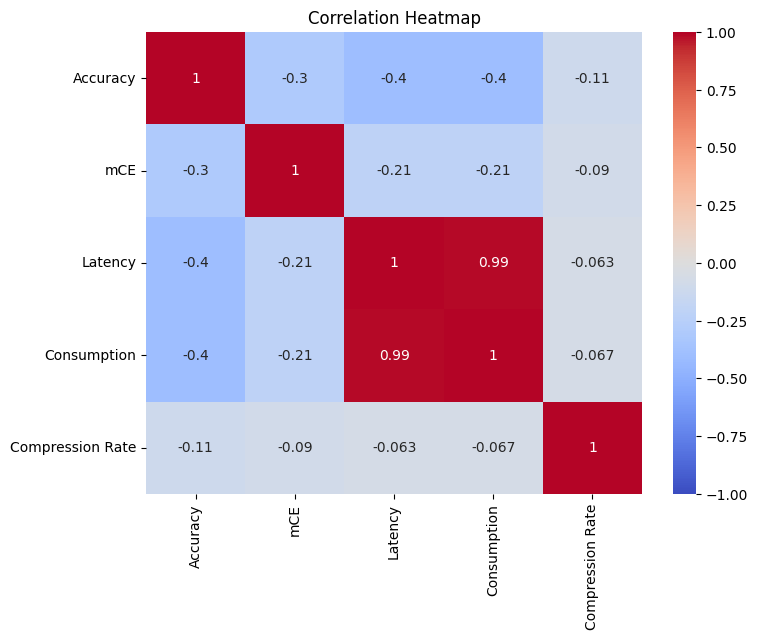

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_final.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Pareto Front

In [ ]:
def find_pareto_front(solutions, minimization_objectives = None):
  """
    Encontra a Frente de Pareto a partir de um conjunto de soluções.

    Args:
        solucoes (np.array): Um array NumPy onde cada linha é uma solução
                             e cada coluna é um objetivo.
        objetivos_minimizacao (list): Uma lista booleana indicando se cada objetivo
                                      deve ser minimizado (True) ou maximizado (False).
                                      Se None, assume-se que todos os objetivos são de minimização.

    Returns:
        np.array: Um array NumPy contendo as soluções que fazem parte da Frente de Pareto.
    """
  n_solutions = solutions.shape[0]
  n_objectives = solutions.shape[1]

  is_pareto = np.ones(n_solutions, dtype=bool)
  if minimization_objectives is None:
    minimization_objectives = [True] * n_objectives

  adapted_solutions = np.copy(solutions).astype(float)
  for i, is_min in enumerate(minimization_objectives):
    if not is_min:
      adapted_solutions[:, i] *= -1

  for i in range(n_solutions):
    for j in range(n_solutions):
      if i != j:
        # Verifica se a solução j domina a solução i
        # (solução j é igual ou melhor em todos os objetivos, e estritamente melhor em pelo menos um)
        domain = np.all(adapted_solutions[j] <= adapted_solutions[i]) and np.any(adapted_solutions[j] < adapted_solutions[i])
        if domain:
          is_pareto[i] = False
          break
  return is_pareto


In [ ]:
def generate_df_pareto_result(metrics_to_evaluate, minimization_objectives):

  assert len(metrics_to_evaluate) == len(minimization_objectives), "metrics_to_evaluate and minimization_objectives must have the same length"

  pareto_data = []
  for dataset in ['cifar10', 'cifar100']:
    df_current = df_final.loc[pd.IndexSlice[:, dataset], :]
    solutions = []
    for metric in metrics_to_evaluate:
        solutions.append(df_current[metric].values)
    solutions = np.array(solutions).T
    pareto_front_mask = find_pareto_front(solutions, minimization_objectives)

    df_pareto_subset = df_current.iloc[pareto_front_mask].copy()
    pareto_data.append(df_pareto_subset)

    # Removi por algo mais simples
    # ordened_x = np.argsort(pareto_front[:, 0])
    # pareto_front = pareto_front[ordened_x]

    # for i, point in enumerate(pareto_front):
    #   condition = None
    #   for j, metric in enumerate(metrics_to_evaluate):
    #     if condition is None:
    #       condition = np.isclose(df_current[metric], point[j])
    #     else:
    #       condition = condition & np.isclose(df_current[metric], point[j])

    #   match = df_current[condition]
    #   if not match.empty:
    #       model = match.index[0][0]
    #       type_name = match.index[0][2]
    #       row_data = {'Model': model, 'Dataset': dataset, 'Type': type_name}
    #       for i, metric in enumerate(metrics_to_evaluate):
    #           row_data[metric] = point[i]
    #       pareto_data.append(row_data)
  if pareto_data:
        df_pareto = pd.concat(pareto_data)
  else:
        df_pareto = pd.DataFrame()
  # df_pareto = pd.DataFrame(pareto_data)
  # df_pareto = df_pareto.set_index(['Model', 'Dataset', 'Type'])
  return df_pareto

In [ ]:
result = generate_df_pareto_result(["Consumption", "Latency", "mCE", "Accuracy", "Compression Rate"], [False, False, True, False, False])
result

Accuracy    mCE   Latency  \
Model        Dataset  Type                                                      
resnet50     cifar10  Pruning Int8                     93.23   77.3  2.614828   
                      PQAT                             93.46   76.7  0.418222   
                      PQAT Int8                        93.45   76.7  3.503937   
                      PCQAT Int8                       92.67   76.7  3.467694   
vgg19        cifar10  Quantization Int8                71.75  101.5  3.545220   
                      Pruning Int8                     76.12   93.5  3.389034   
                      Pruning with Clustering Int8     75.06   95.0  3.533946   
                      CQAT Int8                        74.74   94.8  3.431585   
                      PQAT Int8                        75.70   93.1  3.525821   
                      PCQAT Int8                       74.19   98.4  3.500309   
resnet50     cifar100 Pruning Int8                     76.57   98.5  3.329620   
                      Pruning with Clustering Int8     75.90   97.1  2.891202   
                      CQAT                             77.81   95.5  0.416616   
                      CQAT Int8                        77.67   95.4  3.376278   
                      PQAT                             77.29   95.1  0.413745   
                      PQAT Int8                        77.32   95.4  3.420280   
                      PCQAT Int8                       76.66   98.2  3.413421   
mobilenet_v2 cifar100 Clustering Int8                  68.66  104.1  4.961536   
                      Pruning with Clustering Int8     68.63  103.6  4.931765   
                      CQAT Int8                        69.00  104.8  4.973748   
                      PQAT Int8                        70.92  101.3  4.464261   
vgg19        cifar100 Clustering Int8                  54.59   98.7  4.007658   
                      QAT                              65.45   87.5  1.210271   
                      CQAT                             63.13   91.3  1.234849   
                      CQAT Int8                        63.10   91.2  3.612546   
                      PCQAT Int8                       61.50   91.5  3.985026   

                                                    Consumption  \
Model        Dataset  Type                                        
resnet50     cifar10  Pruning Int8                     3.048898   
                      PQAT                             0.485641   
                      PQAT Int8                        3.013129   
                      PCQAT Int8                       3.042156   
vgg19        cifar10  Quantization Int8                3.185244   
                      Pruning Int8                     3.260764   
                      Pruning with Clustering Int8     3.244445   
                      CQAT Int8                        3.168401   
                      PQAT Int8                        3.242101   
                      PCQAT Int8                       3.191093   
resnet50     cifar100 Pruning Int8                     3.128460   
                      Pruning with Clustering Int8     3.076860   
                      CQAT                             0.508022   
                      CQAT Int8                        3.052796   
                      PQAT                             0.514331   
                      PQAT Int8                        3.104739   
                      PCQAT Int8                       3.103841   
mobilenet_v2 cifar100 Clustering Int8                  2.390203   
                      Pruning with Clustering Int8     2.331210   
                      CQAT Int8                        2.440889   
                      PQAT Int8                        2.382374   
vgg19        cifar100 Clustering Int8                  3.206159   
                      QAT                              1.216901   
                      CQAT                             1.221570   
                      CQAT Int8          

In [ ]:
print(result)

                                                    Accuracy    mCE   Latency  \
Model        Dataset  Type                                                      
resnet50     cifar10  Pruning Int8                     93.23   77.3  2.614828   
                      PQAT                             93.46   76.7  0.418222   
                      PQAT Int8                        93.45   76.7  3.503937   
                      PCQAT Int8                       92.67   76.7  3.467694   
vgg19        cifar10  Quantization Int8                71.75  101.5  3.545220   
                      Pruning Int8                     76.12   93.5  3.389034   
                      Pruning with Clustering Int8     75.06   95.0  3.533946   
                      CQAT Int8                        74.74   94.8  3.431585   
                      PQAT Int8                        75.70   93.1  3.525821   
                      PCQAT Int8                       74.19   98.4  3.500309   
resnet50     cifar100 Prunin

In [ ]:
generate_df_pareto_result(["Consumption", "Latency", "mCE", "Accuracy", "Compression Rate"], [True, True, True, False, False])

Consumption   Latency  \
Model        Dataset  Type                                                  
resnet50     cifar10  Pruning Int8                   132.237035  0.221407   
                      PQAT                           830.196322  1.384294   
                      PQAT Int8                      133.806828  0.165226   
                      PCQAT Int8                     132.530092  0.166953   
mobilenet_v2 cifar10  Clustering                      28.237927  0.073419   
                      Pruning with Clustering         26.815197  0.037867   
                      Pruning with Clustering Int8    10.955166  0.016616   
                      CQAT Int8                       10.938833  0.016292   
                      PQAT Int8                       11.141440  0.015910   
                      PCQAT Int8                      10.967515  0.016411   
vgg19        cifar10  Pruning with Clustering Int8   786.974541  1.152478   
                      PCQAT Int8                     800.131891  1.163553   
resnet50     cifar100 Pruning Int8                   124.851488  0.173865   
                      Pruning with Clustering Int8   126.945303  0.200230   
                      CQAT                           768.850593  1.389544   
                      CQAT Int8                      127.945937  0.171463   
                      PQAT                           759.419320  1.399184   
                      PQAT Int8                      125.805396  0.169257   
                      PCQAT Int8                     125.841771  0.169597   
mobilenet_v2 cifar100 Original                        26.924706  0.073091   
                      Clustering                      26.399586  0.076114   
                      Clustering Int8                 11.264610  0.014731   
                      Pruning with Clustering         25.779312  0.073123   
                      Pruning with Clustering Int8    11.549669  0.014820   
                      QAT                            125.636741  0.226275   
                      CQAT Int8                       11.030697  0.014695   
                      PQAT Int8                       11.301628  0.016372   
                      PCQAT Int8                      10.926245  0.040807   
vgg19        cifar100 QAT                           2144.598184  3.455836   
                      CQAT                          2136.401083  3.387052   
                      CQAT Int8                      808.869360  1.157770   
                      PCQAT Int8                     795.196010  1.049553   

                                                      mCE  Accuracy  \
Model        Dataset  Type                                            
resnet50     cifar10  Pruning Int8                   77.3     93.23   
                      PQAT                           76.7     93.46   
                      PQAT Int8                      76.7     93.45   
                      PCQAT Int8                     76.7     92.67   
mobilenet_v2 cifar10  Clustering                     96.2     90.65   
                      Pruning with Clustering        94.7     90.35   
                      Pruning with Clustering Int8  103.3     88.93   
                      CQAT Int8                      99.0     89.41   
                      PQAT Int8                     106.9     89.59   
                      PCQAT Int8                    108.1     88.22   
vgg19        cifar10  Pruning with Clustering Int8   95.0     75.06   
                      PCQAT Int8                     98.4     74.19   
resnet50     cifar100 Pruning Int8                   98.5     76.57   
                      Pruning with Clustering Int8   97.1     75.90   
                      CQAT                           95.5     77.81   
                      CQAT Int8                      95.4     77.67   
                      PQAT                           95.1     77.29   
                      PQAT Int8                      95.4     77.32   
             

In [ ]:
generate_df_pareto_result(["Latency", "mCE", "Accuracy", "Compression Rate"], [True, True, False, False])

Latency    mCE  Accuracy  \
Model        Dataset  Type                                                      
resnet50     cifar10  PQAT                          1.384397   76.7     93.46   
                      PQAT Int8                     0.165208   76.7     93.45   
                      PCQAT Int8                    0.166896   76.7     92.67   
mobilenet_v2 cifar10  Clustering                    0.073379   96.2     90.65   
                      Pruning with Clustering       0.037858   94.7     90.35   
                      Pruning with Clustering Int8  0.016611  103.3     88.93   
                      CQAT Int8                     0.016280   99.0     89.41   
                      PQAT Int8                     0.015908  106.9     89.59   
                      PCQAT Int8                    0.016406  108.1     88.22   
vgg19        cifar10  Pruning with Clustering Int8  1.152117   95.0     75.06   
                      PCQAT Int8                    1.163378   98.4     74.19   
resnet50     cifar100 Pruning with Clustering Int8  0.199140   97.1     75.90   
                      CQAT                          1.391157   95.5     77.81   
                      CQAT Int8                     0.171432   95.4     77.67   
                      PQAT                          1.399198   95.1     77.29   
                      PQAT Int8                     0.169205   95.4     77.32   
                      PCQAT Int8                    0.169494   98.2     76.66   
mobilenet_v2 cifar100 Original                      0.073086  100.0     71.85   
                      Clustering                    0.076115   97.5     71.88   
                      Clustering Int8               0.014728  104.1     68.66   
                      Pruning with Clustering       0.073125   98.6     71.56   
                      Pruning with Clustering Int8  0.014821  103.6     68.63   
                      CQAT Int8                     0.014693  104.8     69.00   
                      PQAT Int8                     0.016368  101.3     70.92   
                      PCQAT Int8                    0.040801  108.1     66.69   
vgg19        cifar100 QAT                           3.454786   87.5     65.45   
                      CQAT                          3.387028   91.3     63.13   
                      CQAT Int8                     1.155881   91.2     63.10   
                      PCQAT Int8                    1.049516   91.5     61.50   

                                                    Compression Rate  
Model        Dataset  Type                                            
resnet50     cifar10  PQAT                                  3.124723  
                      PQAT Int8                             5.728666  
                      PCQAT Int8                            8.130696  
mobilenet_v2 cifar10  Clustering                            3.681991  
                      Pruning with Clustering               4.438198  
                      Pruning with Clustering Int8          6.903746  
                      CQAT Int8                             5.404243  
                      PQAT Int8                             5.190066  
                      PCQAT Int8                            7.827171  
vgg19        cifar10  Pruning with Clustering Int8          8.991689  
                      PCQAT Int8                            9.427921  
resnet50     cifar100 Pruning with Clustering Int8          8.077711  
                      CQAT                                  4.536470  
                      CQAT Int8                             6.623472  
                      PQAT                                  3.184434  
                      PQAT Int8                             5.748219  
                      PCQAT Int8                            8.599198  
mobilenet_v2 cifar100 Original                              1.000000  
                      Clustering                            3.663339  
                      Clustering Int8             

In [ ]:
result = generate_df_pareto_result(["Compression Rate", "mCE", "Accuracy"], [False, True, False])
result

Compression Rate   mCE  \
Model    Dataset  Type                                                   
resnet50 cifar10  PQAT                                  3.124723  76.7   
                  PQAT Int8                             5.728666  76.7   
                  PCQAT Int8                            8.130696  76.7   
vgg19    cifar10  Pruning with Clustering Int8          8.991689  95.0   
                  PCQAT Int8                            9.427921  98.4   
resnet50 cifar100 Pruning with Clustering Int8          8.077711  97.1   
                  CQAT                                  4.536470  95.5   
                  CQAT Int8                             6.623472  95.4   
                  PQAT                                  3.184434  95.1   
                  PCQAT Int8                            8.599198  98.2   
vgg19    cifar100 QAT                                   2.584576  87.5   
                  CQAT                                  5.353420  91.3   
                  CQAT Int8                             7.247374  91.2   
                  PCQAT Int8                            9.243104  91.5   

                                                Accuracy  
Model    Dataset  Type                                    
resnet50 cifar10  PQAT                             93.46  
                  PQAT Int8                        93.45  
                  PCQAT Int8                       92.67  
vgg19    cifar10  Pruning with Clustering Int8     75.06  
                  PCQAT Int8                       74.19  
resnet50 cifar100 Pruning with Clustering Int8     75.90  
                  CQAT                             77.81  
                  CQAT Int8                        77.67  
                  PQAT                             77.29  
                  PCQAT Int8                       76.66  
vgg19    cifar100 QAT                              65.45  
                  CQAT                             63.13  
                  CQAT Int8                        63.10  
                  PCQAT Int8                       61.50

## Plots

In [ ]:
colors = {
    'resnet50': {
        "marker": 'o',
        "color": '#1f77b4',
    },
    'vgg19': {
        "marker": 'H',
        "color": '#ff7f0e',
    },
    # 'mobilenet': {
    #     "marker": 's',
    #     "color": '#2ca02c',
    # },
    'mobilenet_v2': {
        "marker": 's',
        "color": '#d62728'
    }
}


legends = {
     "Original": 'A',
    'Quantization Int8': 'B',
    'Pruning': 'C',
    'Pruning Int8': 'D',
    'Clustering': 'E',
    'Clustering Int8': 'F',
    'Pruning with Clustering': 'G',
    'Pruning with Clustering Int8': 'H',
    'QAT':'I',
    'QAT Int8': 'J',
    'CQAT': 'K',
    'CQAT Int8': 'L',
    'PQAT': 'M',
    'PQAT Int8': 'N',
    'PCQAT': 'O',
    'PCQAT Int8': 'P',
}

/tmp/ipython-input-3962970437.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x=[x_coords[0]],y=[y_coords[0]], color='blue', label='Original Models', marker=colors[model_name]["marker"], s=200,zorder=10)


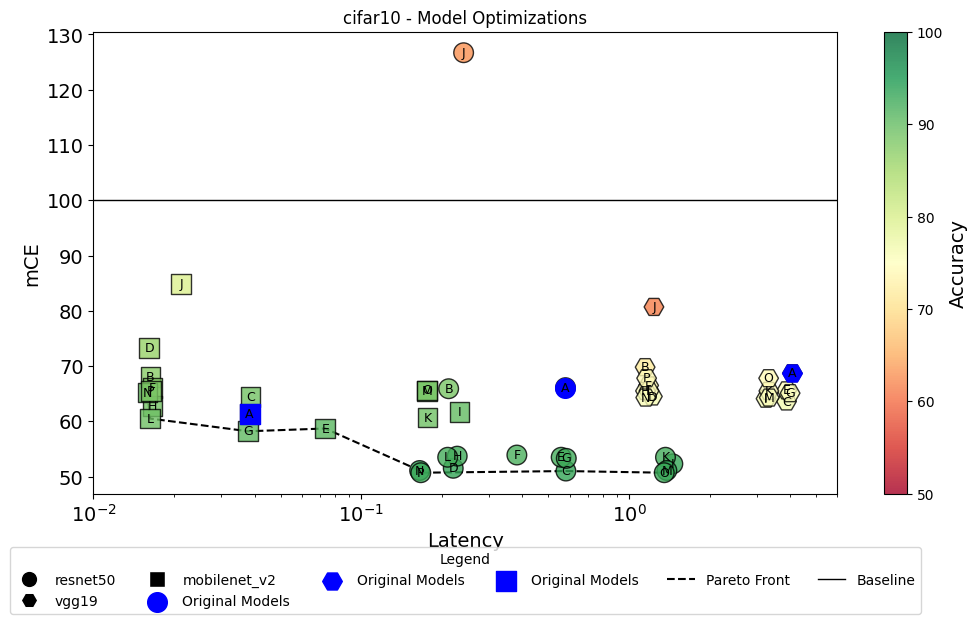

/tmp/ipython-input-3962970437.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x=[x_coords[0]],y=[y_coords[0]], color='blue', label='Original Models', marker=colors[model_name]["marker"], s=200,zorder=10)


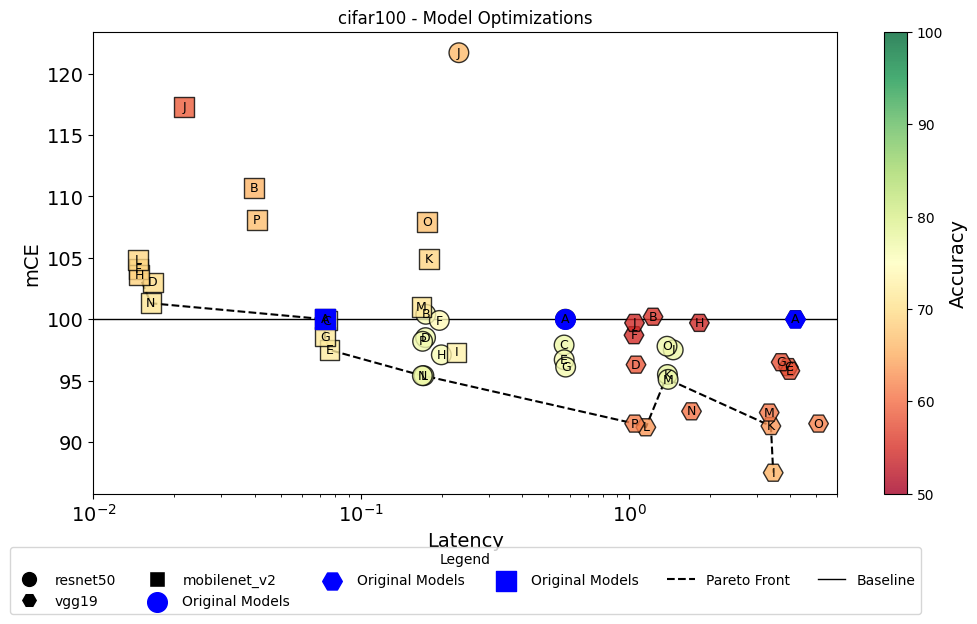

In [ ]:
for dataset in ['cifar10', 'cifar100']:
  df_current = df_final.loc[pd.IndexSlice[:, dataset], :]
  all_x_coords = df_current["Latency"].values
  all_y_coords = df_current["mCE"].values
  all_z_coords = df_current["Accuracy"].values

  combined_solutions = np.column_stack([
      all_x_coords,
      all_y_coords,
      all_z_coords
      ])

  pareto_front = find_pareto_front(combined_solutions, minimization_objectives=[True, True, False])
  ordened_x = np.argsort(pareto_front[:, 0])
  pareto_front = pareto_front[ordened_x]
  types = df_current.index.get_level_values('Type').unique()
  v_min = 50.0
  v_max = 100.0

  plt.figure(figsize=(12, 6))

  # plt.scatter([1], [100], color='blue', label='Original Models', marker='*', s=200,zorder=10)

  model_markers = []
  for model_name in colors.keys():
    model_markers.append(plt.Line2D(
        [0], [0],
        marker=colors[model_name]["marker"],  # A simple marker to represent the annotated point
        color='w',   # White color as the actual text is black
        label=model_name, # Label for the legend
        markerfacecolor='k', # Black marker face color
        markersize=12
    ))
    data = df_current.loc[model_name]
    x_coords = data["Latency"]
    y_coords = data["mCE"]
    z_coords = data["Accuracy"]
    scatter = plt.scatter(
        # x=x_coords[1:],
        # y=y_coords[1:],
        # c=z_coords[1:],
        x=x_coords,
        y=y_coords,
        c=z_coords,
        s=200,
        cmap='RdYlGn',
        edgecolor='k',
        marker=colors[model_name]["marker"],
        alpha=0.8,
        vmin=v_min,
        vmax=v_max,
        # label=model_name
      )
    plt.scatter(x=[x_coords[0]],y=[y_coords[0]], color='blue', label='Original Models', marker=colors[model_name]["marker"], s=200,zorder=10)

    for type_name, row in data.iterrows():
      current_point = (row['Latency'], row['mCE'], row['Accuracy'])
      letter = legends[type_name[1]]
      plt.text(
          row['Latency'],
          row['mCE'],
          letter,
          fontsize=9,
          ha='center',
          va='center',
          color='black',
          zorder=10
      )

  cbar = plt.colorbar(scatter)
  cbar.set_label("Accuracy", fontsize=14)

  annotation_proxies = []

  for key, value in legends.items():
    annotation_proxies.append(plt.Line2D(
        [0], [0],
        marker='None',  # A simple marker to represent the annotated point
        color='w',   # White color as the actual text is black
        label=f'{value} - {key}', # Label for the legend
        markerfacecolor='k', # Black marker face color
        markersize=8
    ))

  plt.plot(
      pareto_front[:, 0],
      pareto_front[:, 1],
      color='black',
      linestyle='--',
      markersize=8,
      label='Pareto Front',
      zorder=0
  )

  plt.plot([0, 10], [100, 100], color='black', label='Baseline', linewidth=1, zorder=0)
  # Combine existing legend handles and labels
  handles, labels = plt.gca().get_legend_handles_labels()

  # Add the annotation proxies to the handles and labels
  handles = model_markers + handles
  # handles.extend(annotation_proxies)
  labels = [proxy.get_label() for proxy in model_markers] + labels
  # labels.extend([proxy.get_label() for proxy in annotation_proxies])


  plt.xlim(0, 6)
  plt.title(f"{dataset} - Model Optimizations")
  plt.xlabel("Latency", fontsize=14)
  plt.ylabel("mCE", fontsize=14)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)

  plt.xscale('log')
  plt.xlim(0.01, 6)

  plt.legend(handles, labels, loc='upper center', title="Legend", bbox_to_anchor=(0.5, -0.1), ncol=6)
  plt.savefig("cifar100.pdf", dpi=300, bbox_inches='tight')
  plt.show()

/tmp/ipython-input-1042521109.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x=[x_coords[0]],y=[y_coords[0]], color='blue', marker=colors[model_name]["marker"], s=200,zorder=10)


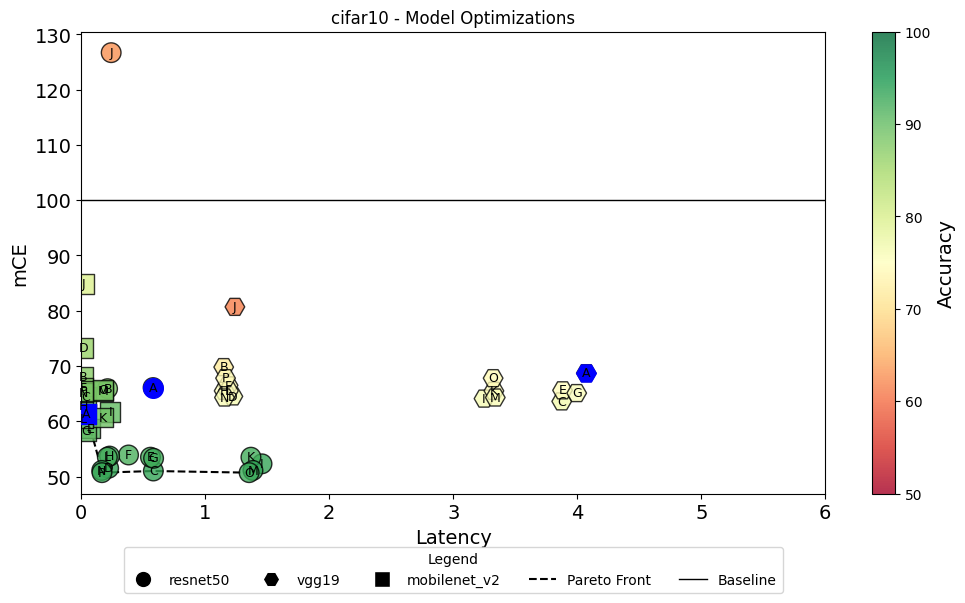

/tmp/ipython-input-1042521109.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(x=[x_coords[0]],y=[y_coords[0]], color='blue', marker=colors[model_name]["marker"], s=200,zorder=10)


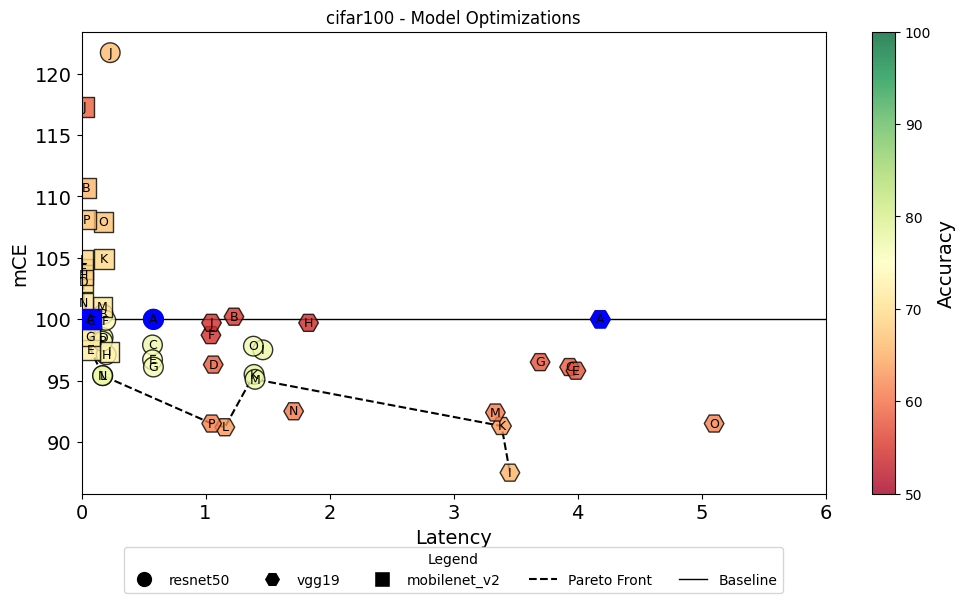

In [ ]:
for dataset in ['cifar10', 'cifar100']:
  df_current = df_final.loc[pd.IndexSlice[:, dataset], :]
  all_x_coords = df_current["Latency"].values
  all_y_coords = df_current["mCE"].values
  all_z_coords = df_current["Accuracy"].values

  combined_solutions = np.column_stack([
      all_x_coords,
      all_y_coords,
      all_z_coords
      ])

  pareto_front = find_pareto_front(combined_solutions, minimization_objectives=[True, True, False])
  ordened_x = np.argsort(pareto_front[:, 0])
  pareto_front = pareto_front[ordened_x]
  types = df_current.index.get_level_values('Type').unique()
  v_min = 50.0
  v_max = 100.0

  plt.figure(figsize=(12, 6))

  # plt.scatter([1], [100], color='blue', label='Original Models', marker='*', s=200,zorder=10)

  model_markers = []
  for model_name in colors.keys():
    model_markers.append(plt.Line2D(
        [0], [0],
        marker=colors[model_name]["marker"],  # A simple marker to represent the annotated point
        color='w',   # White color as the actual text is black
        label=model_name, # Label for the legend
        markerfacecolor='k', # Black marker face color
        markersize=12
    ))
    data = df_current.loc[model_name]
    x_coords = data["Latency"]
    y_coords = data["mCE"]
    z_coords = data["Accuracy"]
    scatter = plt.scatter(
        # x=x_coords[1:],
        # y=y_coords[1:],
        # c=z_coords[1:],
        x=x_coords,
        y=y_coords,
        c=z_coords,
        s=200,
        cmap='RdYlGn',
        edgecolor='k',
        marker=colors[model_name]["marker"],
        alpha=0.8,
        vmin=v_min,
        vmax=v_max,
        # label=model_name
      )
    plt.scatter(x=[x_coords[0]],y=[y_coords[0]], color='blue', label='Original Models', marker=colors[model_name]["marker"], s=200,zorder=10)

    for type_name, row in data.iterrows():
      current_point = (row['Latency'], row['mCE'], row['Accuracy'])
      letter = legends[type_name[1]]
      plt.text(
          row['Latency'],
          row['mCE'],
          letter,
          fontsize=9,
          ha='center',
          va='center',
          color='black',
          zorder=10
      )

  cbar = plt.colorbar(scatter)
  cbar.set_label("Accuracy", fontsize=14)

  annotation_proxies = []

  for key, value in legends.items():
    annotation_proxies.append(plt.Line2D(
        [0], [0],
        marker='None',  # A simple marker to represent the annotated point
        color='w',   # White color as the actual text is black
        label=f'{value} - {key}', # Label for the legend
        markerfacecolor='k', # Black marker face color
        markersize=8
    ))

  plt.plot(
      pareto_front[:, 0],
      pareto_front[:, 1],
      color='black',
      linestyle='--',
      markersize=8,
      label='Pareto Front',
      zorder=0
  )

  plt.plot([0, 10], [100, 100], color='black', label='Baseline', linewidth=1, zorder=0)
  # Combine existing legend handles and labels
  handles, labels = plt.gca().get_legend_handles_labels()

  # Add the annotation proxies to the handles and labels
  handles = model_markers + handles
  # handles.extend(annotation_proxies)
  labels = [proxy.get_label() for proxy in model_markers] + labels
  # labels.extend([proxy.get_label() for proxy in annotation_proxies])


  plt.xlim(0, 6)
  plt.title(f"{dataset} - Model Optimizations")
  plt.xlabel("Latency", fontsize=14)
  plt.ylabel("mCE", fontsize=14)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)

  # plt.xscale('log')
  # plt.xlim(0.01, 6)

  plt.legend(handles, labels, loc='upper center', title="Legend", bbox_to_anchor=(0.5, -0.1), ncol=6)
  plt.savefig("cifar100.pdf", dpi=300, bbox_inches='tight')
  plt.show()

In [ ]:
df_filtered_mce = df_final[df_final['mCE'] <= 100]

# Get the unique types that appear for each model in both datasets
types_per_model_dataset = df_filtered_mce.groupby(['Model', 'Dataset'])['Types'].unique()

# Find types that are common to all models in both datasets
common_types = None
for (model, dataset), types in types_per_model_dataset.items():
    if common_types is None:
        common_types = set(types)
    else:
        common_types = common_types.intersection(set(types))

# Filter the original DataFrame to include only the common types across all models and datasets
df_final_filtered = df_final[df_final.index.get_level_values('Types').isin(common_types)]

display(df_final_filtered)

KeyError: 'Column not found: Types'

## Friedman Test

In [ ]:
!pip install aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [ ]:
from aeon.visualisation import plot_critical_difference

In [ ]:
df_final

Accuracy    mCE   Latency  Consumption  \
Model    Dataset  Type                                                        
resnet50 cifar10  Original              88.42  100.0  1.000000     1.000000   
                  Quantization Int8     88.38   99.6  2.721330     2.961607   
                  Pruning               93.26   76.7  0.996513     1.022697   
                  Pruning Int8          93.23   77.3  2.614828     3.048898   
                  Clustering            92.03   81.3  1.037683     0.963730   
...                                       ...    ...       ...          ...   
vgg19    cifar100 CQAT Int8             63.10   91.2  3.612546     3.226433   
                  PQAT                  60.75   92.4  1.253267     1.219135   
                  PQAT Int8             60.67   92.5  2.574048     3.265199   
                  PCQAT                 61.67   91.5  0.819132     1.224445   
                  PCQAT Int8            61.50   91.5  3.985026     3.281911   

                                     Compression Rate  
Model    Dataset  Type                                 
resnet50 cifar10  Original                   1.000000  
                  Quantization Int8          4.139178  
                  Pruning                    1.637459  
                  Pruning Int8               5.653282  
                  Clustering                 4.532907  
...                                               ...  
vgg19    cifar100 CQAT Int8                  7.247374  
                  PQAT                       3.599820  
                  PQAT Int8                  5.980276  
                  PCQAT                      6.704296  
                  PCQAT Int8                 9.243104  

[96 rows x 5 columns]

In [ ]:
df_final["mCE"]

Model     Dataset   Type             
resnet50  cifar10   Original             100.0
                    Quantization Int8     99.6
                    Pruning               76.7
                    Pruning Int8          77.3
                    Clustering            81.3
                                         ...  
vgg19     cifar100  CQAT Int8             91.2
                    PQAT                  92.4
                    PQAT Int8             92.5
                    PCQAT                 91.5
                    PCQAT Int8            91.5
Name: mCE, Length: 96, dtype: float64

In [ ]:
def rank_metric_by_model(df, metric = 'mCE', ascending = True):
  """
  Ranks the mCE values by model.

  Args:
    df: DataFrame with 'Model', 'Dataset', 'Type', and 'mCE' columns.

  Returns:
    DataFrame: DataFrame with ranked metric values for each model and dataset.
  """
  ranked = df.groupby(['Model', 'Dataset'])[metric].rank(ascending=ascending)
  ranked_df = df.copy()
  ranked_df[f'{metric}_Rank'] = ranked
  return ranked_df.sort_values(by=['Model', 'Dataset', f'{metric}_Rank'])

def generate_ranked_dfs(df_final, metric = 'mCE', ascending = True):
  df_ranked_mce = rank_metric_by_model(df_final.reset_index(), metric=metric, ascending=ascending)
  df_ranked_mce.set_index(['Model', 'Dataset', 'Type'], inplace=True)

  # df_cifar10_ranked = df_ranked_mce.loc[pd.IndexSlice[:, 'cifar10'], :]
  # df_cifar100_ranked = df_ranked_mce.loc[pd.IndexSlice[:, 'cifar100'], :]

  return df_ranked_mce

In [ ]:
from scipy import stats

def friedman_test(df_ranked, metric = 'mCE'):

  # Reshape the data for the Friedman test
  # The Friedman test requires the data to be in a specific format:
  # rows represent blocks (combinations of Model and Dataset in this case)
  # columns represent treatments (Type in this case)
  # the values are the ranks (mCE_Rank)
  # Pivot the dataframe to get 'Type' as columns and combinations of 'Model' and 'Dataset' as index
  df_pivot = df_ranked.reset_index().pivot_table(index=['Model', 'Dataset'], columns='Type', values=f'{metric}_Rank')

  # Extract the data as a list of arrays, where each array is a column (Type)
  data = [df_pivot[column].values for column in df_pivot.columns]
  # Perform the Friedman test
  friedman_result = stats.friedmanchisquare(*data)

  print(f"Friedman test statistic: {friedman_result.statistic}")
  print(f"Friedman test p-value: {friedman_result.pvalue}")

  return friedman_result

In [ ]:
def generate_critical_difference(df_ranked_mce, output_png, plot_title, metric='mCE',lower_better=True, test='wilcoxon', correction='holm'):
  df_pivot = df_ranked_mce.reset_index().pivot_table(index=['Model', 'Dataset'], columns='Type', values=f'{metric}_Rank')
  scores = df_pivot.values
  classifiers = df_pivot.columns.tolist()
  plot_critical_difference(
    scores,
    classifiers,
    lower_better=lower_better,
    test=test,  # or nemenyi
    correction=correction, # or bonferroni or none
  )

  ax = plt.gca()
  ax.set_title(plot_title)

  # Adjust font size and rotation of x-axis labels
  for label in ax.get_xticklabels():
      label.set_fontsize(14)
      label.set_rotation(45)
      label.set_horizontalalignment('right')

  # Increase padding between labels and axis
  ax.tick_params(axis='x', which='major', pad=20)

  ax.tick_params(axis='x', which='major', pad=20)

  # Adjust margins to provide more space for labels
  plt.subplots_adjust(bottom=0.35)

  # Optionally adjust y-axis label font size
  ax.tick_params(axis='y', labelsize=12)

  # Save and display the plot
  # plt.savefig(output_png, format="png", bbox_inches="tight", dpi=300)
  plt.show()

### mCE

In [ ]:
df_ranked = generate_ranked_dfs(df_final, metric='mCE', ascending=True)

In [ ]:
df_ranked

Accuracy    mCE   Latency  \
Model        Dataset  Type                                                      
mobilenet_v2 cifar10  Pruning with Clustering          90.35   94.7  1.010747   
                      Clustering                       90.65   96.2  0.521317   
                      CQAT Int8                        89.41   99.0  2.349304   
                      CQAT                             89.20   99.7  0.217006   
                      Original                         89.76  100.0  1.000000   
...                                                      ...    ...       ...   
vgg19        cifar100 Clustering Int8                  54.59   98.7  4.007658   
                      Pruning with Clustering Int8     54.11   99.7  2.391571   
                      QAT Int8                         54.42   99.7  3.989154   
                      Original                         55.89  100.0  1.000000   
                      Quantization Int8                55.27  100.2  3.399528   

                                                    Consumption  \
Model        Dataset  Type                                        
mobilenet_v2 cifar10  Pruning with Clustering          1.025720   
                      Clustering                       0.974041   
                      CQAT Int8                        2.514426   
                      CQAT                             0.274023   
                      Original                         1.000000   
...                                                         ...   
vgg19        cifar100 Clustering Int8                  3.206159   
                      Pruning with Clustering Int8     3.276746   
                      QAT Int8                         3.206099   
                      Original                         1.000000   
                      Quantization Int8                3.216286   

                                                    Compression Rate  mCE_Rank  
Model        Dataset  Type                                                      
mobilenet_v2 cifar10  Pruning with Clustering               4.438198       1.0  
                      Clustering                            3.681991       2.0  
                      CQAT Int8                             5.404243       3.0  
                      CQAT                                  3.520989       4.0  
                      Original                              1.000000       5.0  
...                                                              ...       ...  
vgg19        cifar100 Clustering Int8                       6.962391      12.0  
                      Pruning with Clustering Int8          8.570426      13.5  
                      QAT Int8                              4.532748      13.5  
                      Original                              1.000000      15.0  
                      Quantization Int8                     4.532745      16.0  

[96 rows x 6 columns]

In [ ]:
friedman_test(df_ranked, metric = 'mCE')

Friedman test statistic: 49.84990157480312
Friedman test p-value: 1.2740351875229646e-05


FriedmanchisquareResult(statistic=np.float64(49.84990157480312), pvalue=np.float64(1.2740351875229646e-05))

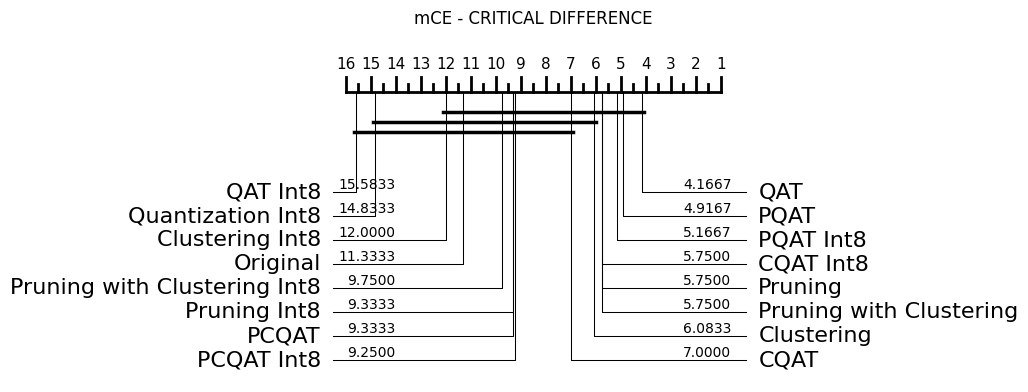

In [ ]:
generate_critical_difference(df_ranked, 'mce_cd.pdf', 'mCE - CRITICAL DIFFERENCE', test='nemenyi')

In [ ]:
# friedman_test(df_cifar100_ranked, metric = 'mCE')

In [ ]:
# generate_critical_difference(df_cifar100_ranked, 'critical_difference_diagram_cifar100.png', 'CRITICAL DIFFERENCE - CIFAR-10', test='nemenyi')

### Accuracy

In [ ]:
df_ranked = generate_ranked_dfs(df_final, metric='Accuracy', ascending=False)

In [ ]:
friedman_test(df_ranked, metric = 'Accuracy')

Friedman test statistic: 51.573529411764696
Friedman test p-value: 6.642879905608475e-06


FriedmanchisquareResult(statistic=np.float64(51.573529411764696), pvalue=np.float64(6.642879905608475e-06))

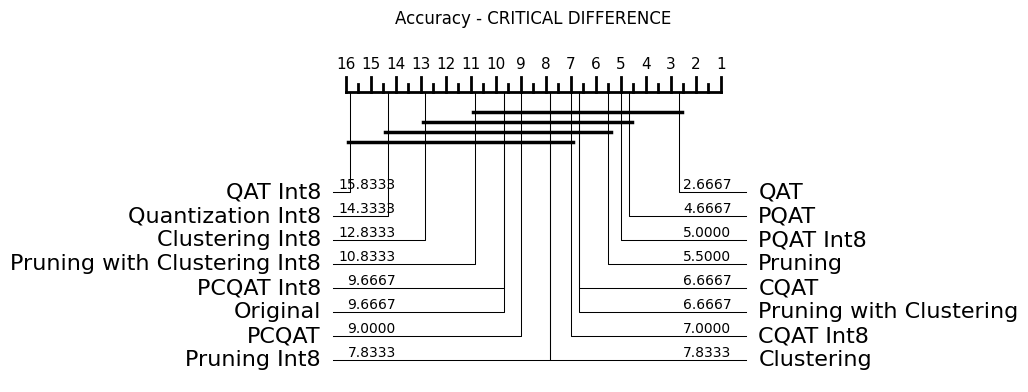

In [ ]:
generate_critical_difference(
    df_ranked,
    'critical_difference_diagram_cifar10.png',
    'Accuracy - CRITICAL DIFFERENCE',
    metric='Accuracy',
    test='nemenyi',
    )

In [ ]:
# friedman_test(df_cifar100_ranked, metric = 'Accuracy')

In [ ]:
# df_cifar100_ranked

### Latency

In [ ]:
df_ranked = generate_ranked_dfs(df_final, metric='Latency', ascending=False)

In [ ]:
friedman_test(df_ranked, metric = 'Latency')

Friedman test statistic: 71.86764705882354
Friedman test p-value: 2.0721709810155736e-09


FriedmanchisquareResult(statistic=np.float64(71.86764705882354), pvalue=np.float64(2.0721709810155736e-09))

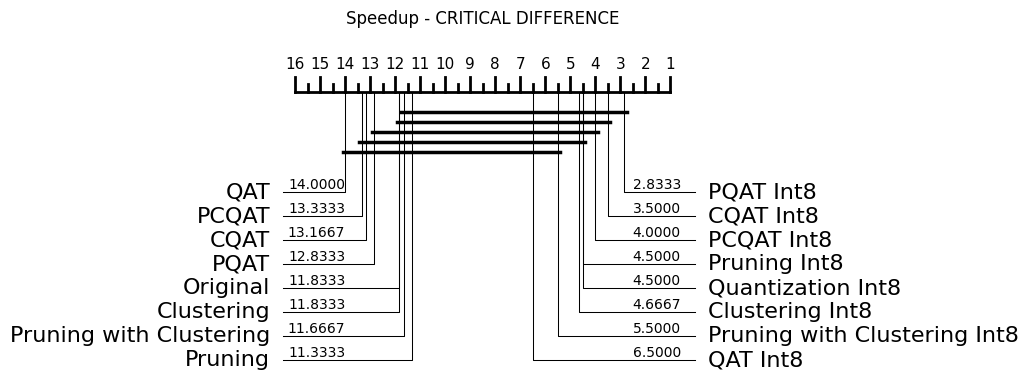

In [ ]:
generate_critical_difference(
    df_ranked,
    'critical_difference_diagram_cifar10.png',
    'Speedup - CRITICAL DIFFERENCE',
    metric='Latency',
    test='nemenyi',
    )

### Consumption

In [ ]:
df_ranked = generate_ranked_dfs(df_final, metric='Consumption', ascending=False)

In [ ]:
friedman_test(df_ranked, metric = 'Consumption')

Friedman test statistic: 75.80882352941177
Friedman test p-value: 4.043101401991936e-10


FriedmanchisquareResult(statistic=np.float64(75.80882352941177), pvalue=np.float64(4.043101401991936e-10))

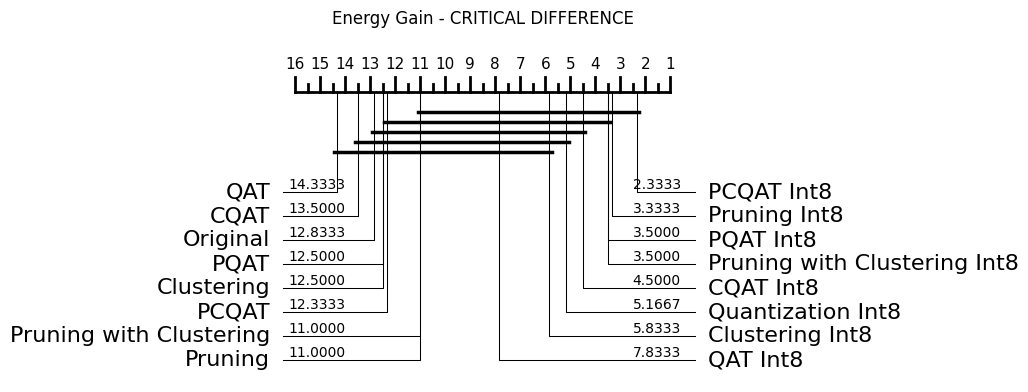

In [ ]:
generate_critical_difference(
    df_ranked,
    'critical_difference_diagram_cifar10.png',
    'Energy Gain - CRITICAL DIFFERENCE',
    metric='Consumption',
    test='nemenyi',
    )

In [ ]:
df_ranked = generate_ranked_dfs(df_final, metric='Compression Rate', ascending=False)

In [ ]:
friedman_test(df_ranked, metric = 'Compression Rate')

Friedman test statistic: 87.91176470588232
Friedman test p-value: 2.428198441156065e-12


FriedmanchisquareResult(statistic=np.float64(87.91176470588232), pvalue=np.float64(2.428198441156065e-12))

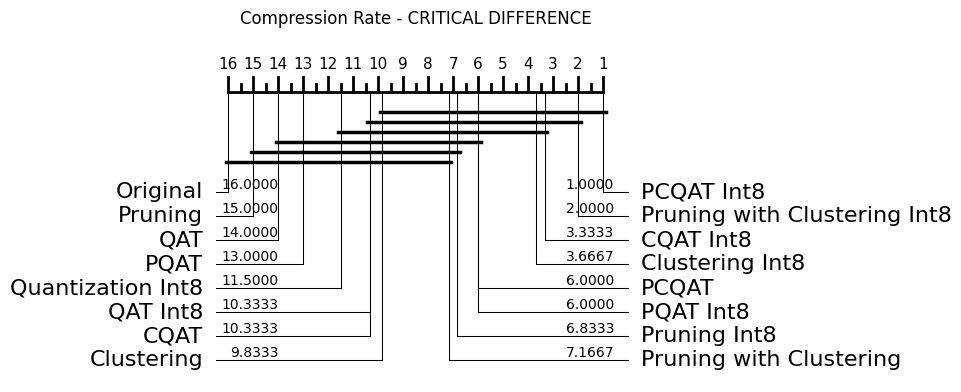

In [ ]:
generate_critical_difference(
    df_ranked,
    'critical_difference_diagram_cifar10.png',
    'Compression Rate - CRITICAL DIFFERENCE',
    metric='Compression Rate',
    test='nemenyi',
    )